# Allen Cell Types
# Exploratory Data Analysis

## Setup

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
plt.style.use('plot_style.txt')

In [3]:
dir_path = os.getcwd()
mouse_data = pd.read_csv(dir_path + '/data/mouse/ephys_data.csv')
human_data = pd.read_csv(dir_path + '/data/human/ephys_data.csv')
savepath = dir_path + '/results/eda'

In [4]:
ctc = CellTypesCache()
cells = ctc.get_cells(species=[CellTypesApi.MOUSE])

## Inspect the electrophysiological response of a neuron according to a stimulus

In [5]:
def get_stimulation_and_response():
    for ind, cell in enumerate(cells):
        cell_id = cell['id']
        data_set = ctc.get_ephys_data(cell_id)
        sweeps = ctc.get_ephys_sweeps(cell_id)
        noise_sweep_number = [x['sweep_number'] for x in sweeps
                              if x['stimulus_name'] in ['Noise 1', 'Noise 2']
                              and x['num_spikes'] is not None
                              and x['num_spikes'] > 10]
        if not noise_sweep_number:
            continue

        try:
            sweep_data = data_set.get_sweep(noise_sweep_number[0])
            return sweep_data
        except:
            continue

In [6]:
def plot_stimulation_and_response(data):
    relevant_signal = range(*data['index_range'])
    stimulation = data['stimulus'][relevant_signal]  # in A
    stimulation *= 1e12  # to pA
    response = data['response'][relevant_signal]  # in V
    response *= 1e3  # to mV

    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    axes[0].plot(np.linspace(0, 9, len(relevant_signal)), stimulation, 'b-', linewidth=0.5, alpha=0.7)
    axes[0].set_xlabel('Seconds')
    axes[0].set_ylabel('pA')
    axes[0].set_title('Stimulation')

    axes[1].plot(np.linspace(0, 9, len(relevant_signal)), response, 'r-', linewidth=0.1, alpha=0.7)
    axes[1].set_xlabel('Seconds')
    axes[1].set_ylabel('mV')
    axes[1].set_ylim([-80, 50])
    axes[1].set_title('Response')

    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Electrophysiological activity of a neuron')
    plt.show()
    fig.savefig(savepath + "/stimulation_response.png")

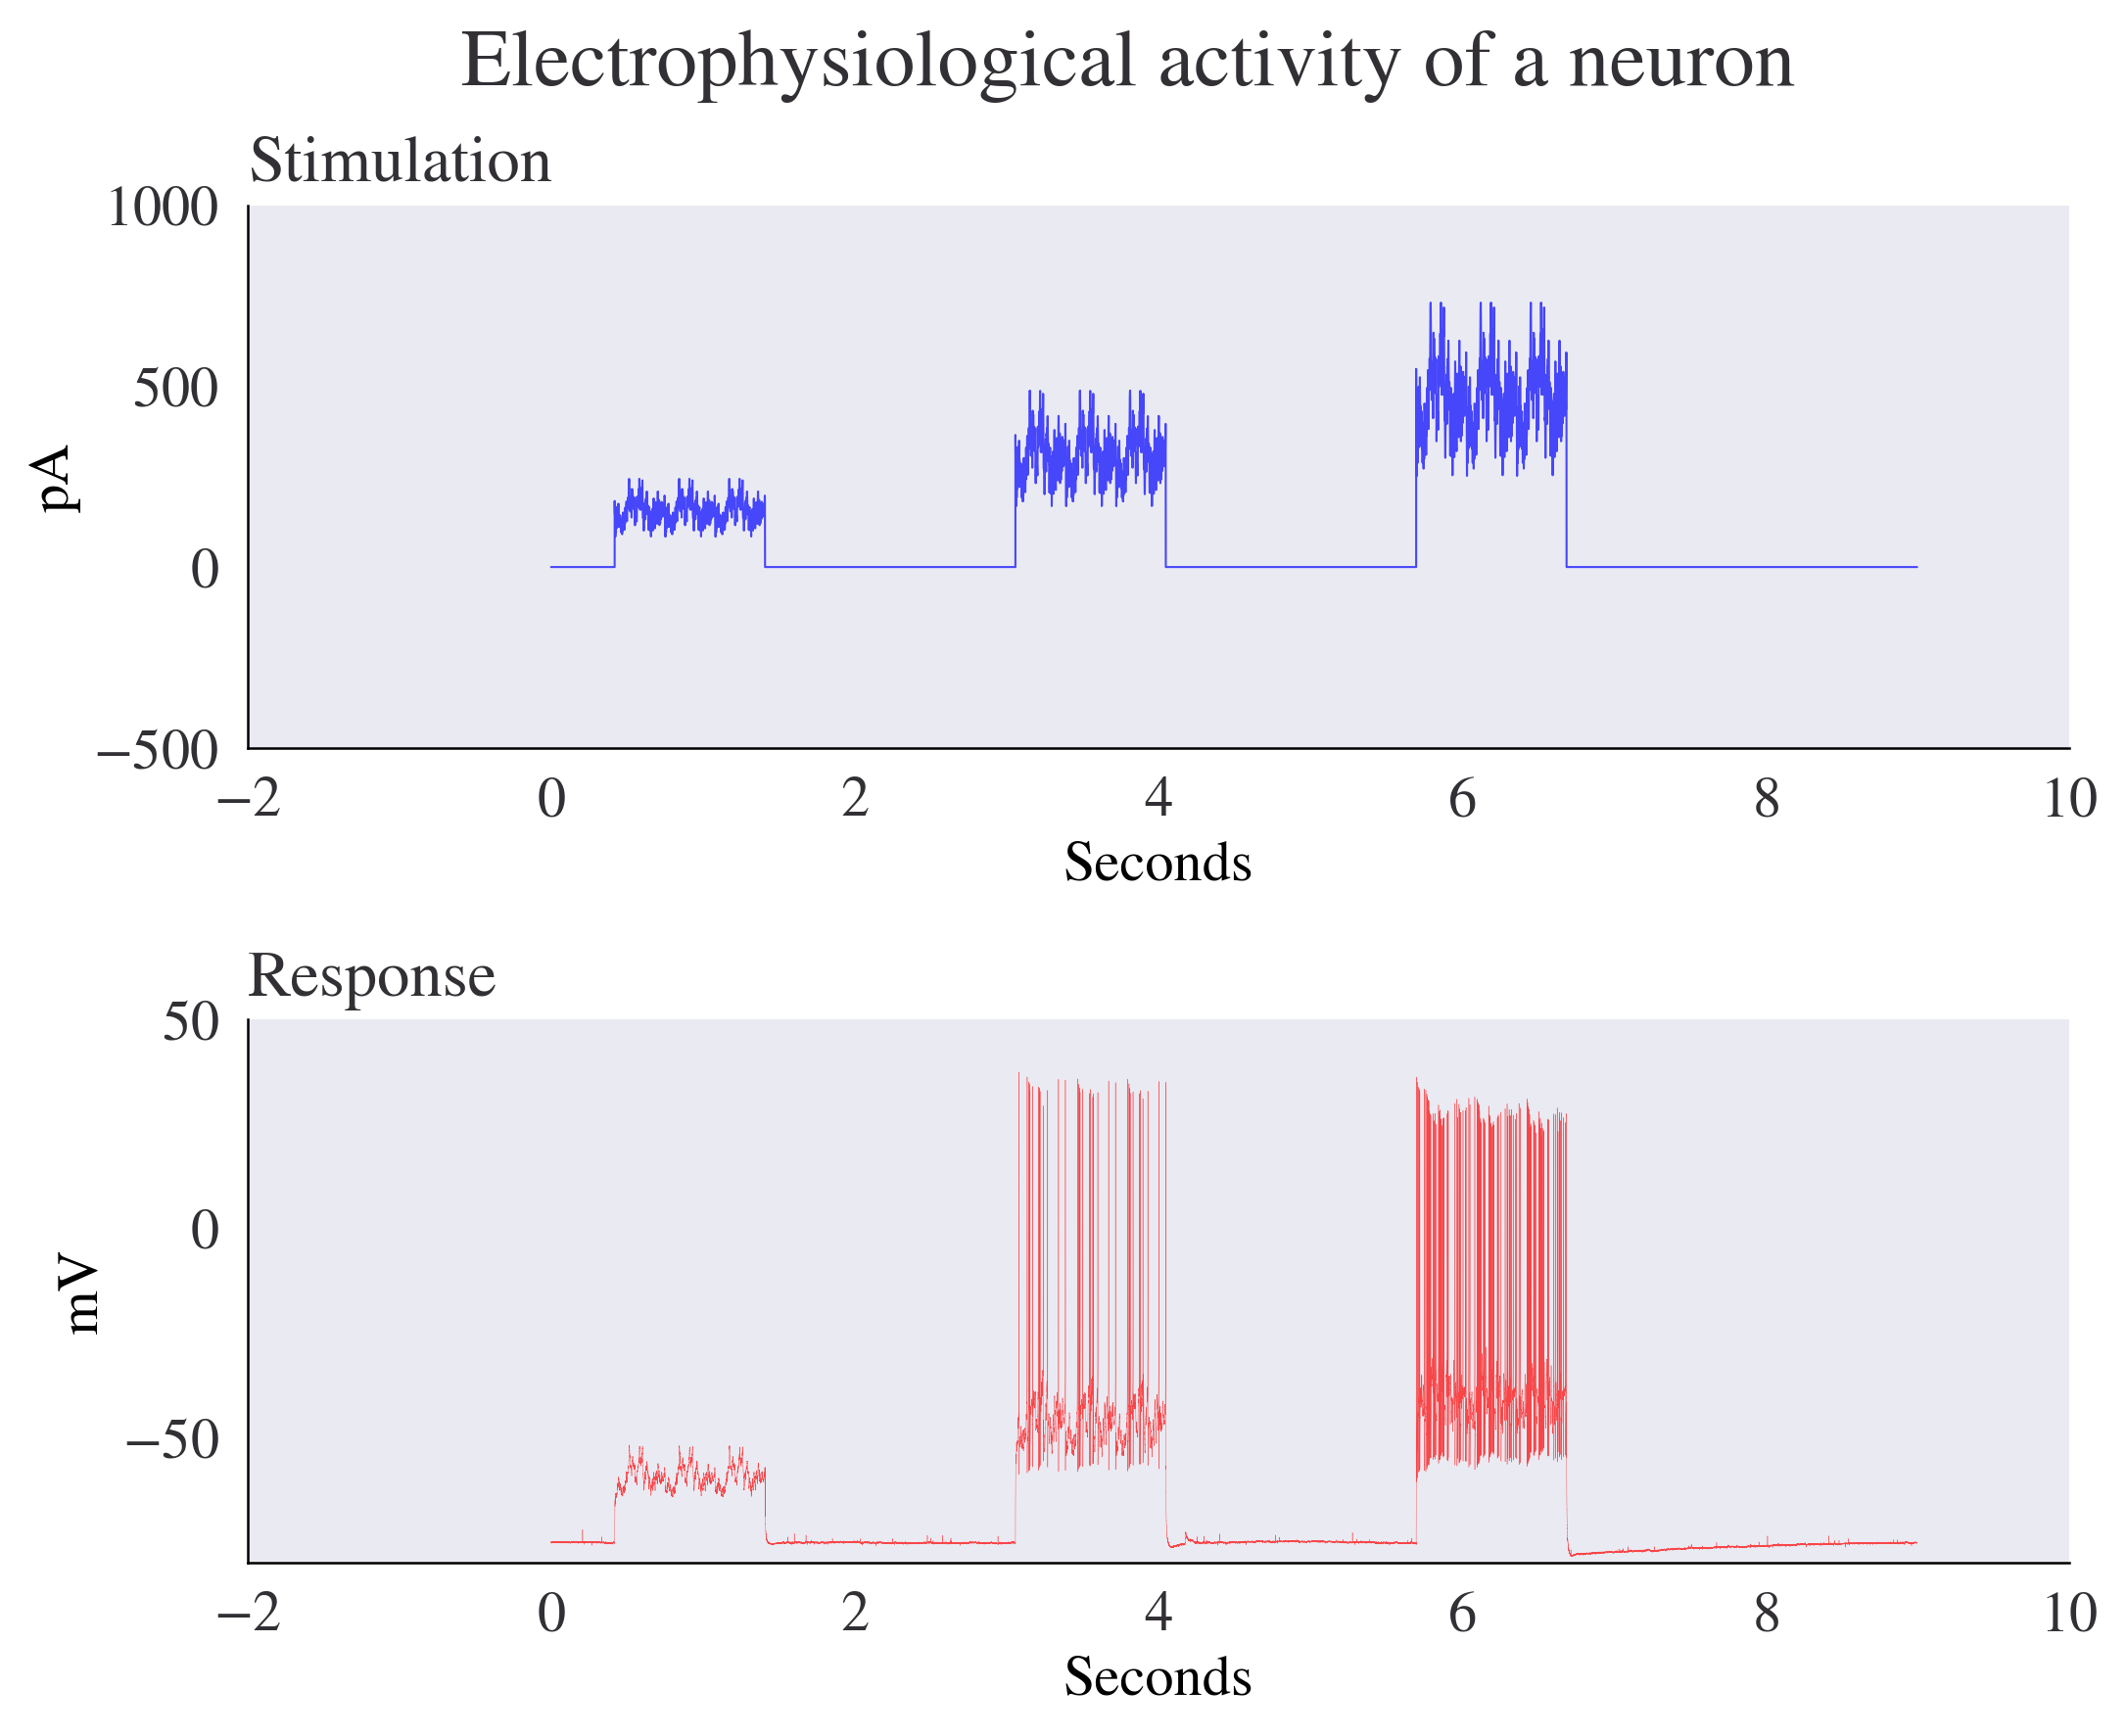

In [7]:
sweep_data = get_stimulation_and_response()
plot_stimulation_and_response(sweep_data)

## What is the distribution of excitatory and inhibitory cells in the data?

In [8]:
def plot_cell_distribution():
    fig, axes = plt.subplots(1, 2, sharey='all', figsize=(8, 6))
    fig.suptitle('Distribution of inhibitory/excitatory cells')

    axes[0].set_title('Mouse data')
    ax0 = sns.countplot(ax=axes[0], x="dendrite_type", data=mouse_data, palette="Set2",
                        order=['spiny', 'aspiny'])
    ax0.bar_label(ax0.containers[0])
    ax0.set(xlabel=None)

    axes[1].set_title('Human data')
    ax1 = sns.countplot(ax=axes[1], x="dendrite_type", data=human_data, palette="Set2",
                        order=['spiny', 'aspiny'])
    ax1.bar_label(ax1.containers[0])
    ax1.set(xlabel=None)

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath + "/dendrite_type.png")

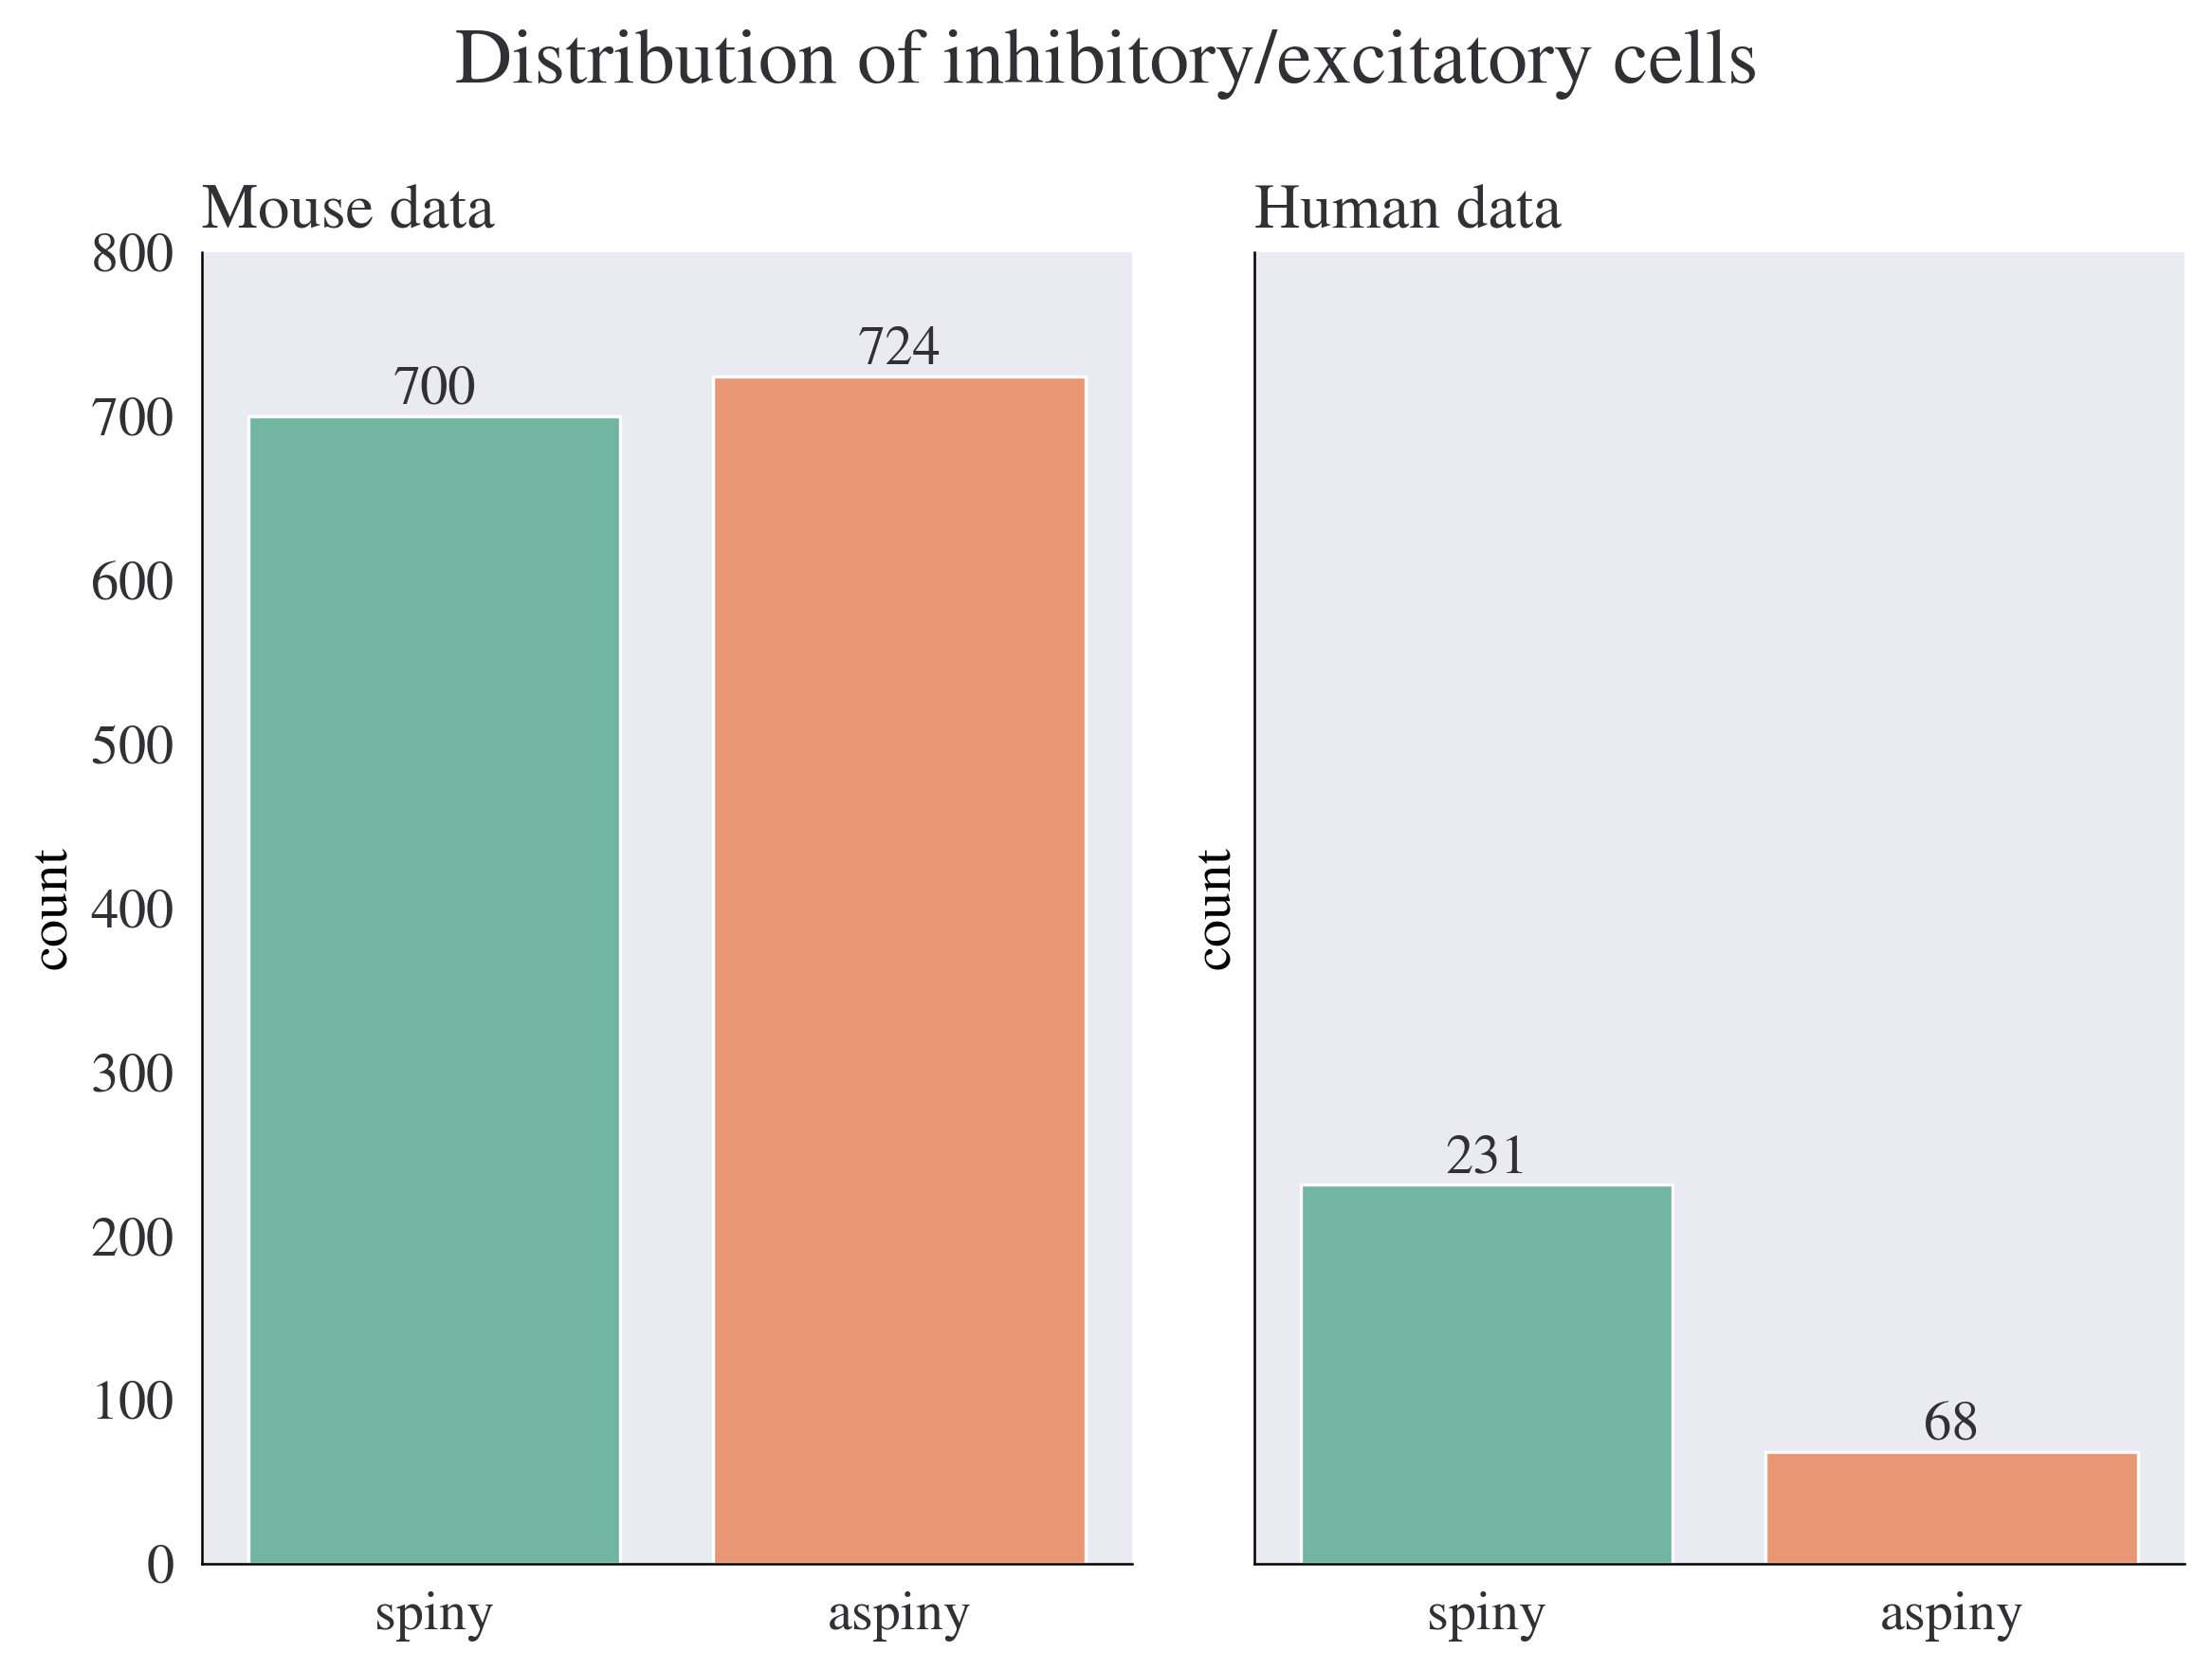

In [9]:
plot_cell_distribution()

## What is the distribution of Cre-line targeting in the data?

In [10]:
def plot_types():
    fig, ax = plt.subplots(1, 1, sharey='all', figsize=(8, 6))
    ax.set_title('Mouse data')
    fig.suptitle('Distribution of t-types')
    ax = sns.countplot(x="transgenic_line", data=mouse_data, palette="Set2",
                       order=mouse_data['transgenic_line'].value_counts().index)
    ax.bar_label(ax.containers[0])
    ax.set(xlabel=None)
    plt.tight_layout()
    plt.show()
    fig.savefig(savepath + "/t_type.png")

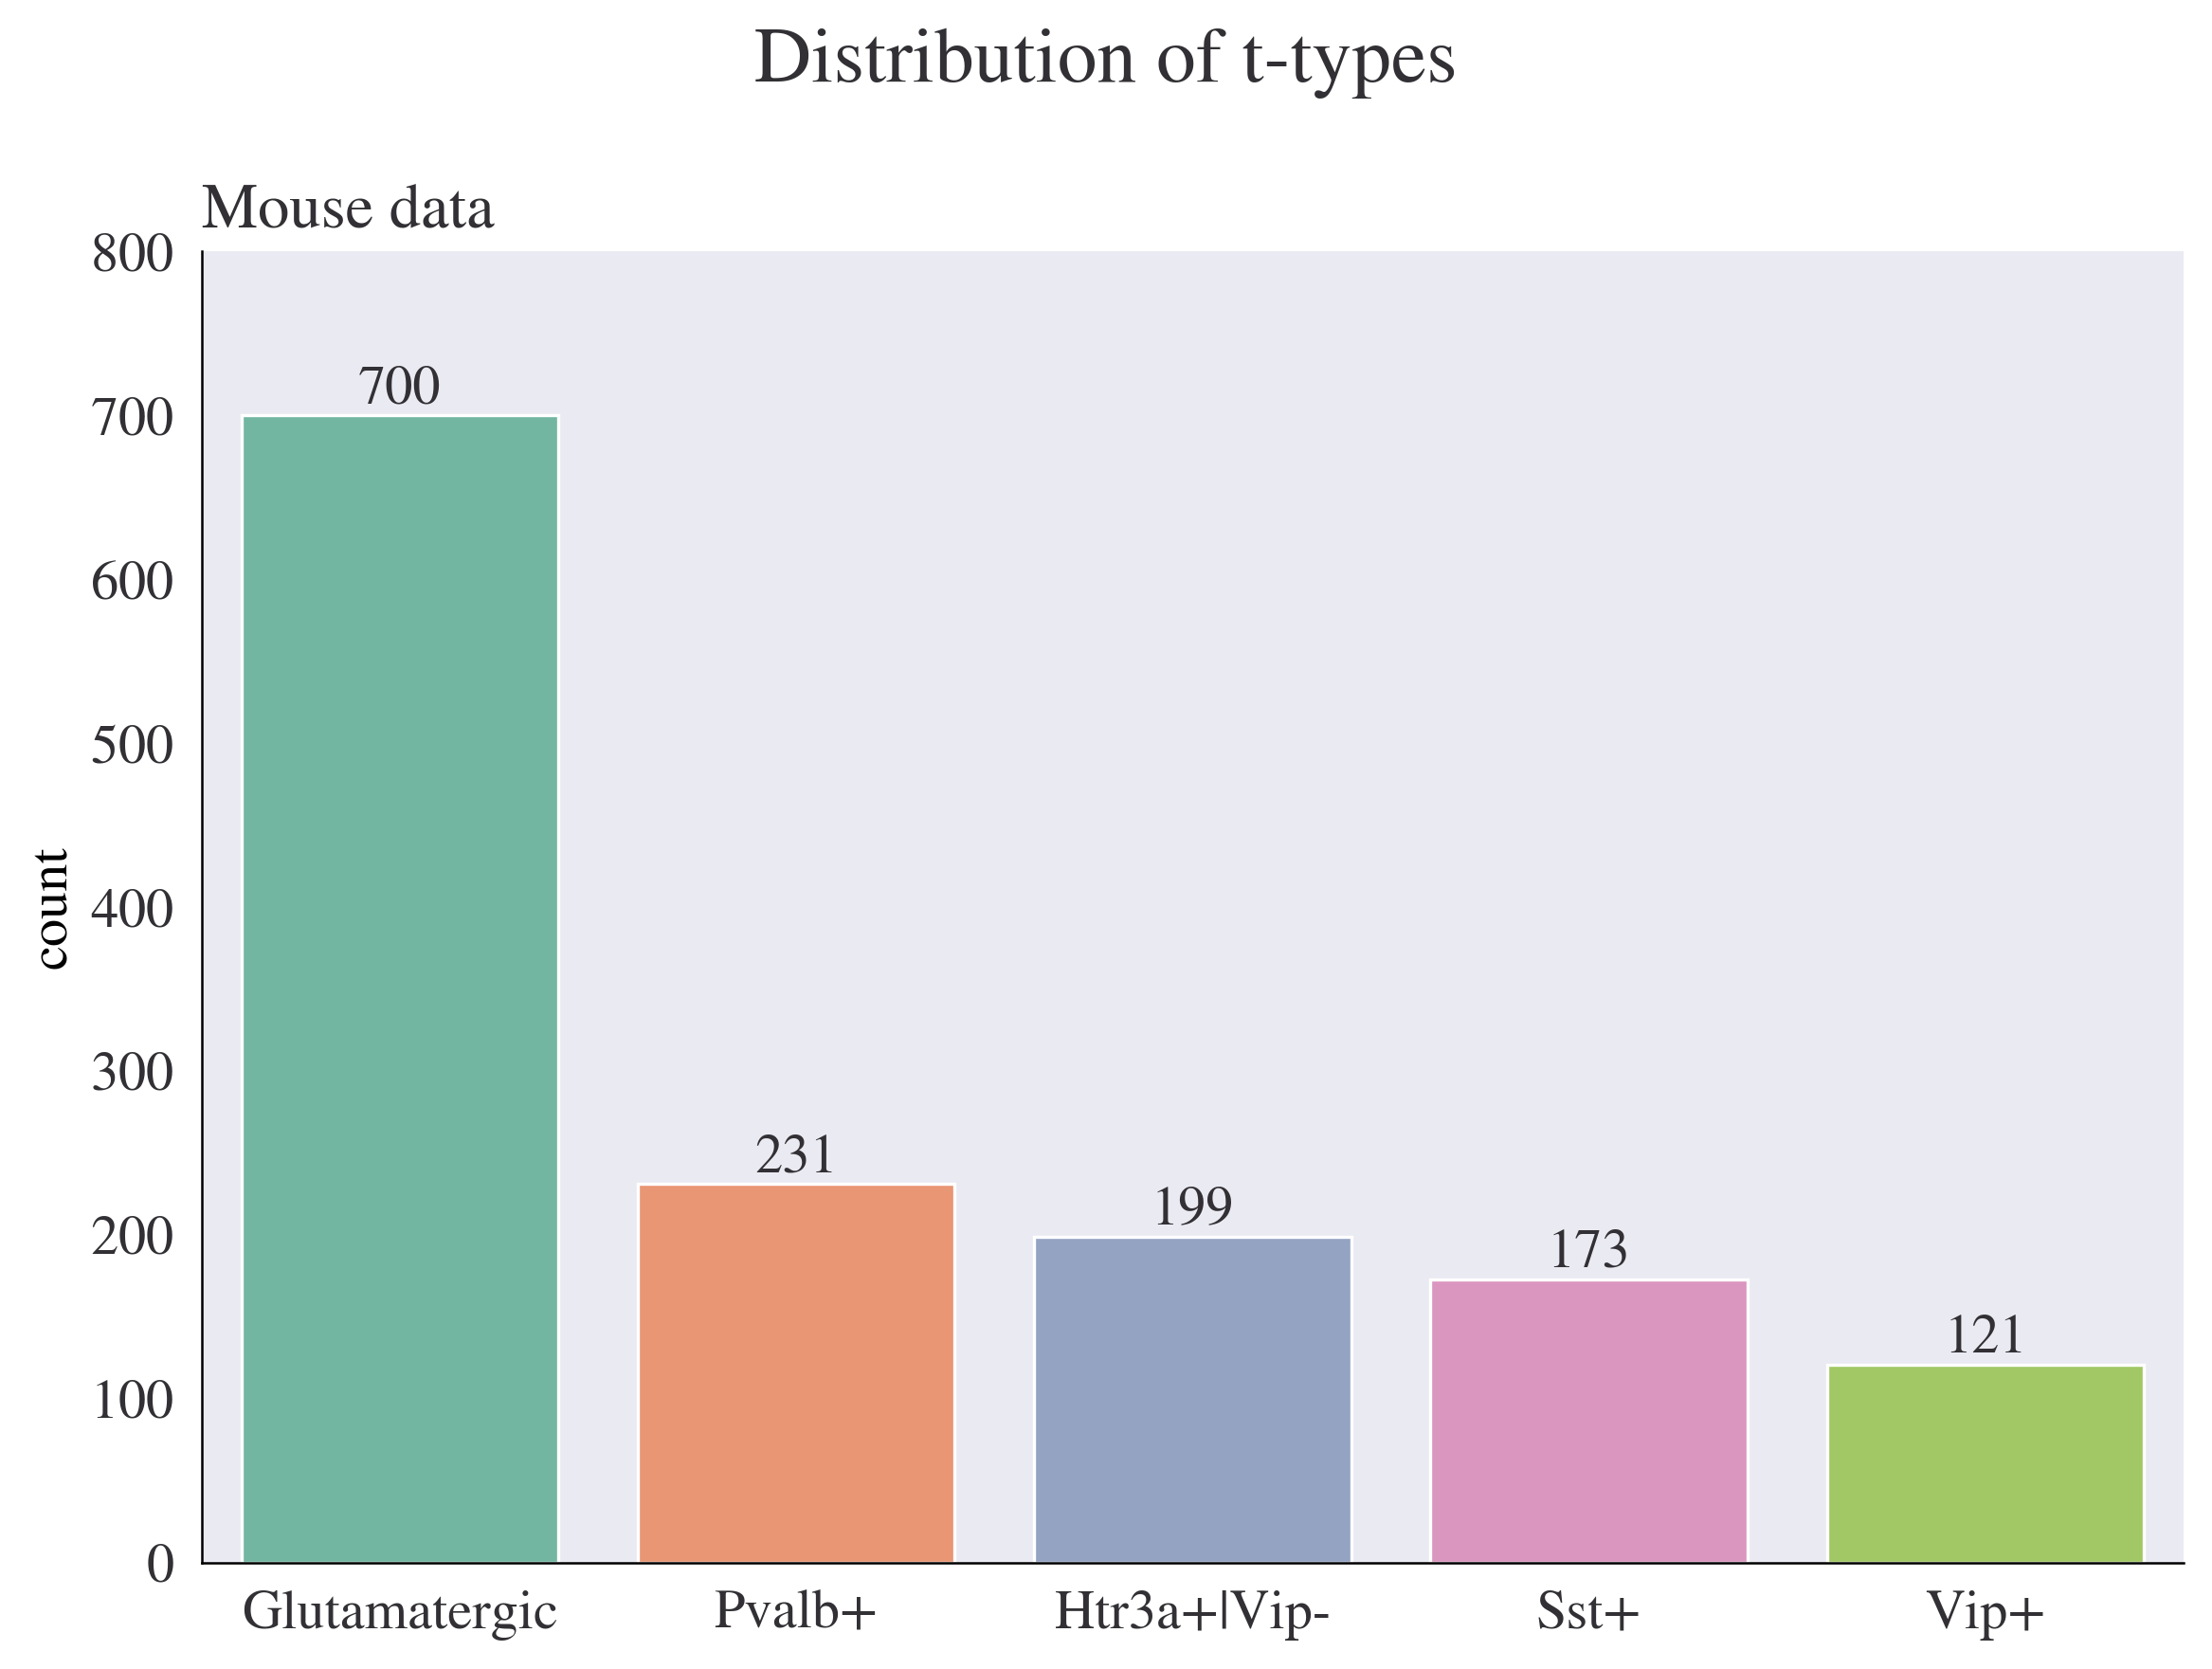

In [11]:
plot_types()

## What is the Cre-line distribution in each layer?

In [12]:
def plot_cre_line_in_layers():
    fig = plt.figure(figsize=(12, 10))
    fig.suptitle('Distribution of Cre-lines in each layer')
    g = sns.countplot(x="layer", data=mouse_data, hue="transgenic_line",
                      order=['L1', 'L2/L3', 'L4', 'L5', 'L6a', 'L6b'], palette="Set2")
    total = float(len(mouse_data))
    for p in g.axes.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width()
        y = p.get_height()
        g.axes.annotate(percentage, (x, y), ha='right', va='baseline', rotation=50, fontsize='medium')

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath + "/t_type_layer.png")

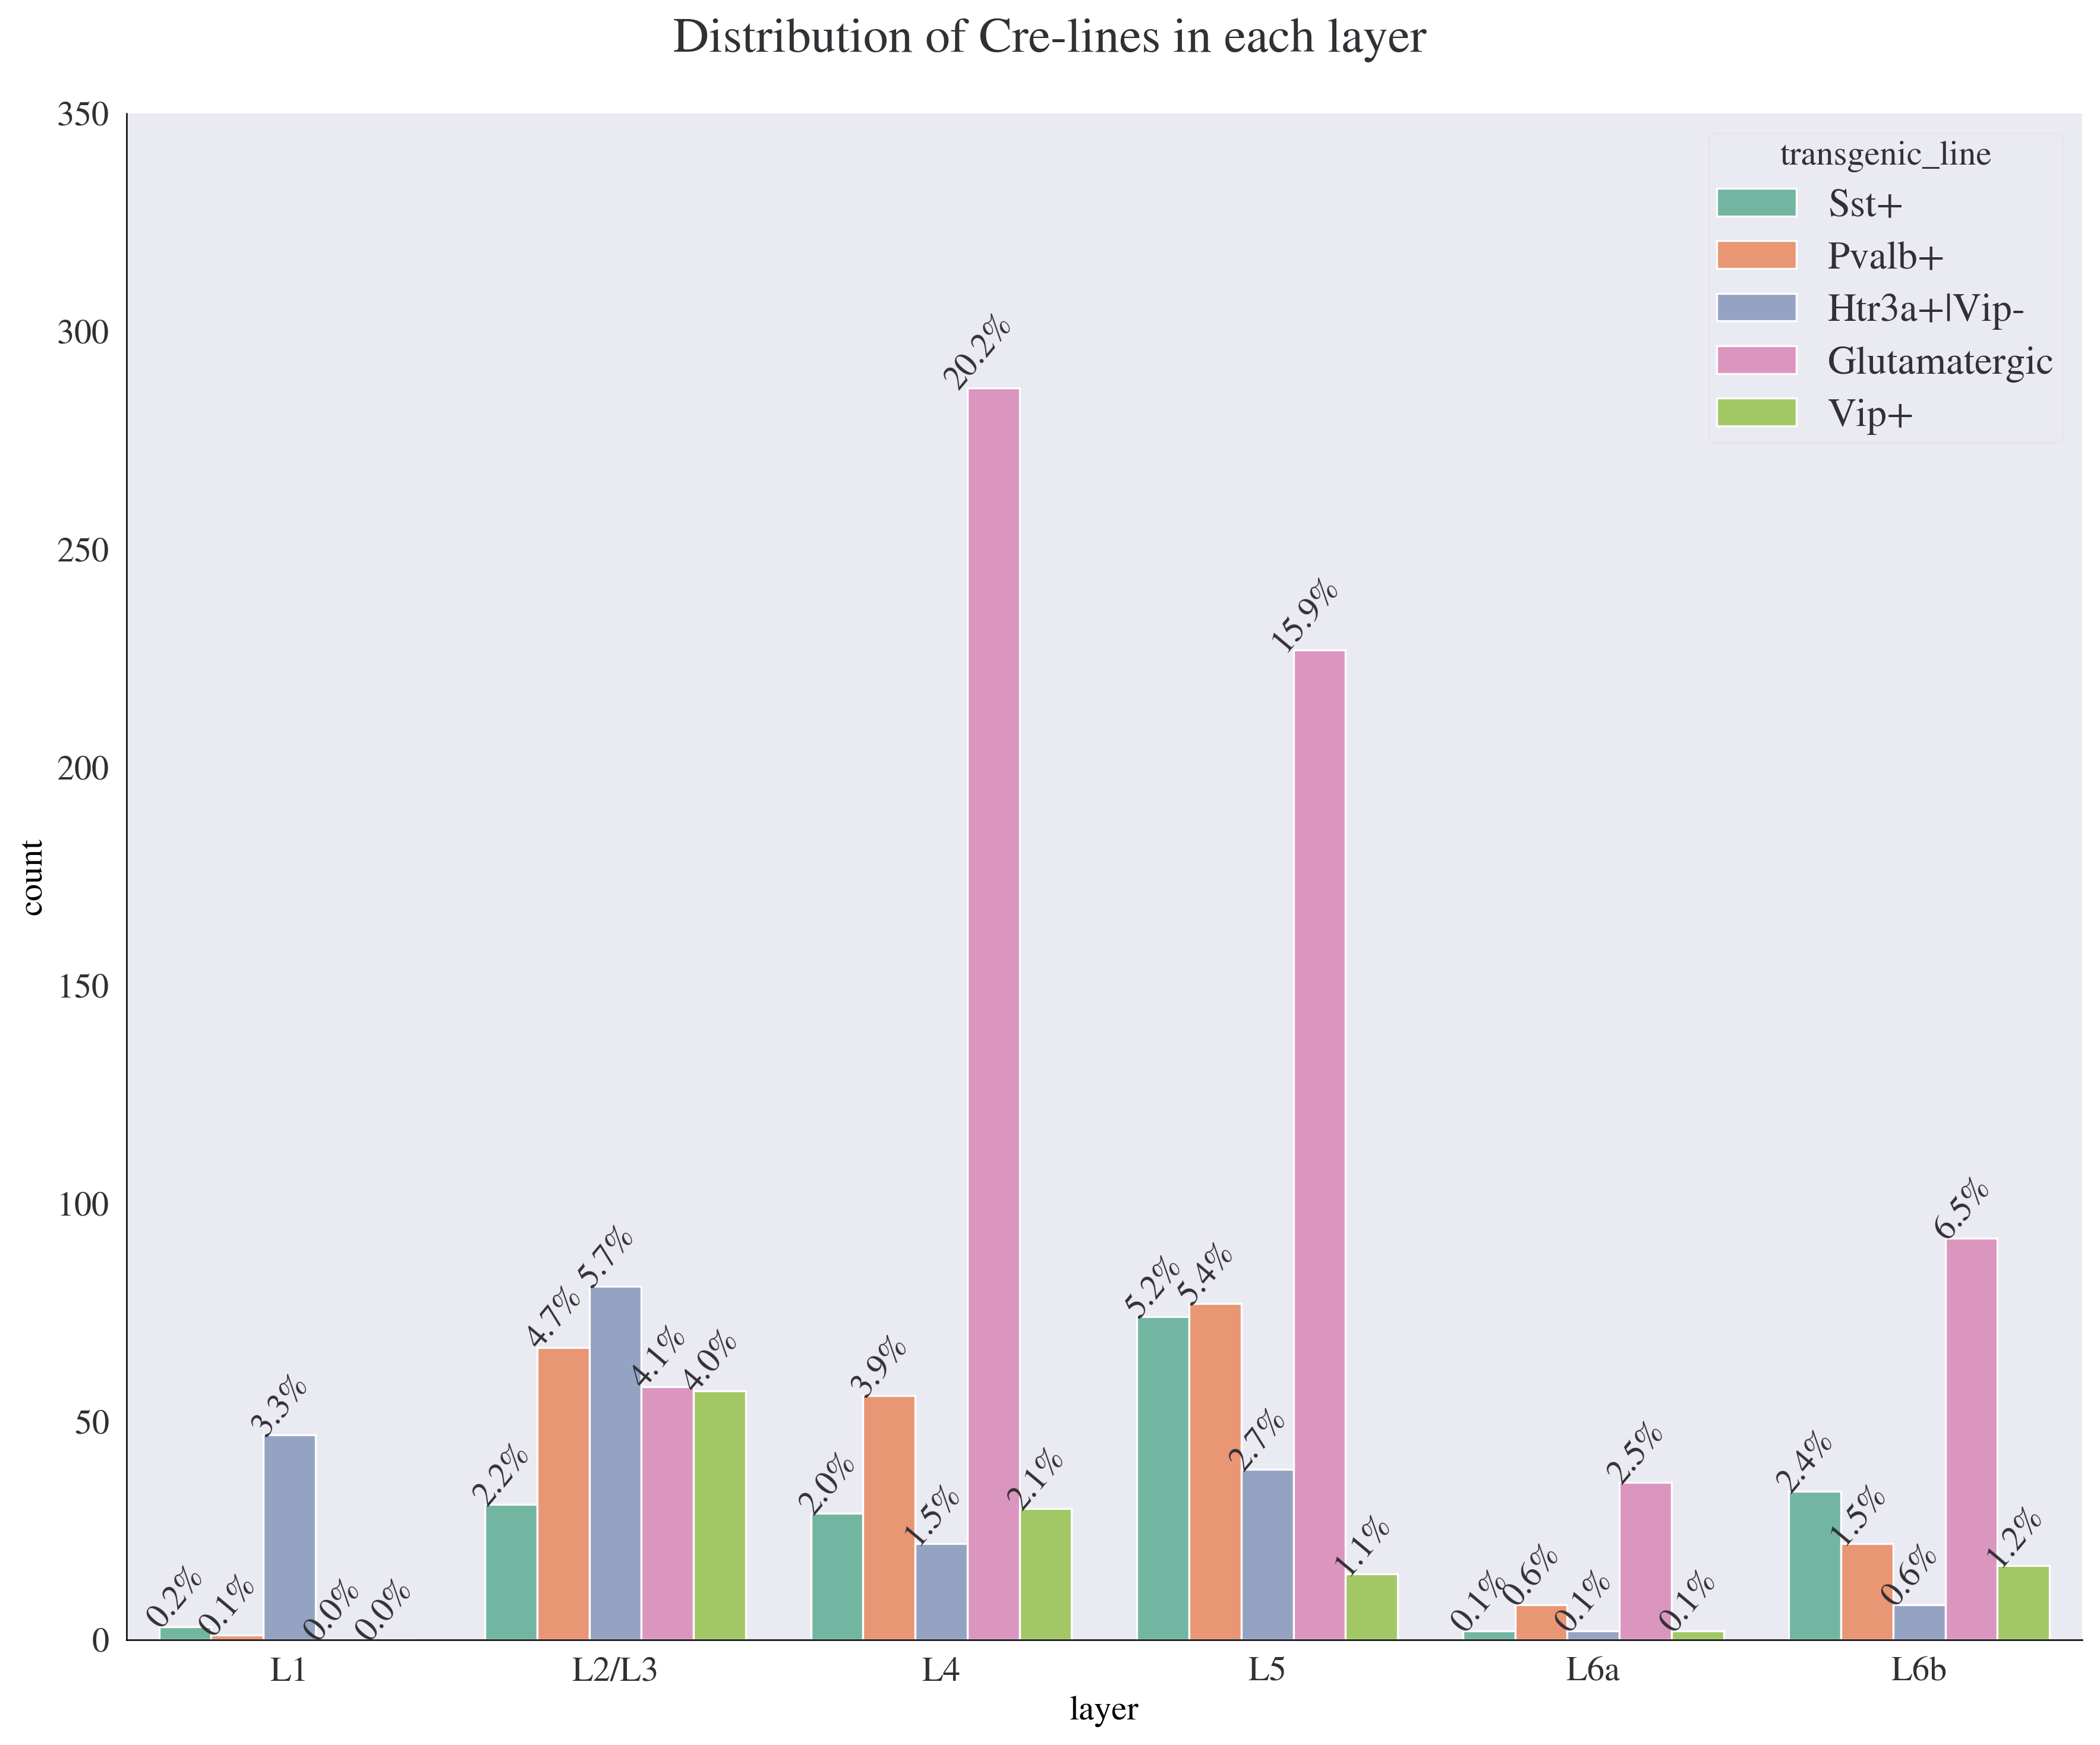

In [13]:
plot_cre_line_in_layers()

## single-spike EDA

In [14]:
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

In [15]:
data_mouse = pd.read_csv(dir_path + '/data/mouse/single_spike_data.csv')

### Analysis on Pvalb L5 mouse cell 481127932

#### Short square stimulus

In [16]:
ctc = CellTypesCache()
cell_specimen_id = 481127932
data_set = ctc.get_ephys_data(cell_specimen_id)

sweep_data = data_set.get_sweep(11)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] * 1e12
v = sweep_data["response"][0:index_range[1]+1] * 1e3
t = np.arange(0, len(v)) * (1.0 / sweep_data["sampling_rate"])

sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i)
sweep_ext.process_spikes()
result = {}
for key in sweep_ext.spike_feature_keys():
    try:
        result[key] = sweep_ext.spike_feature(key)
    except TypeError:
        print("No valid Key")
ephys_data = pd.DataFrame.from_dict(result)

Text(0.0, 1.0, 'Stimulation')

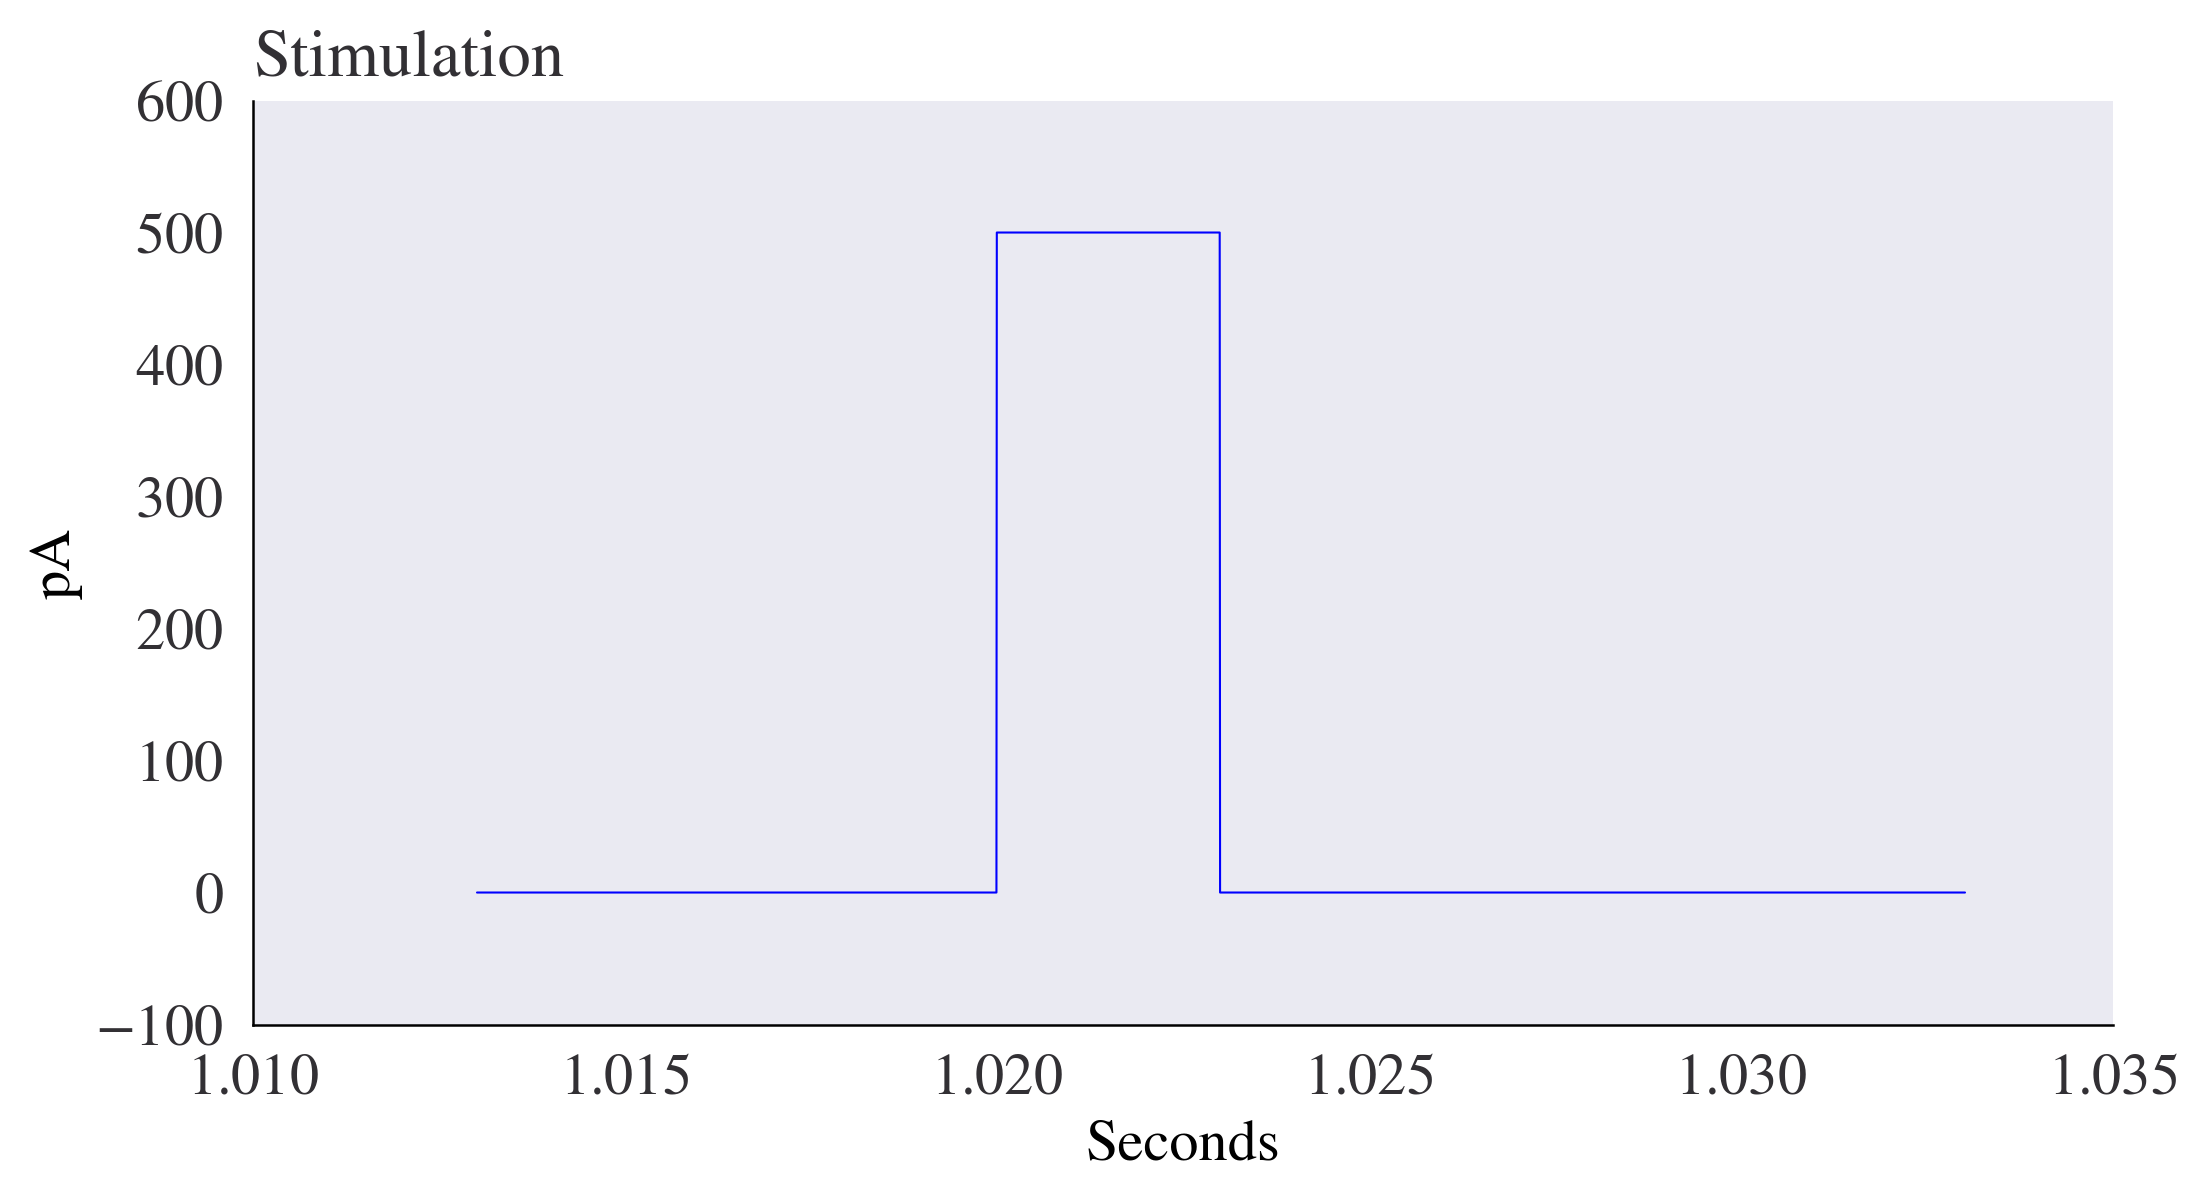

In [17]:
buffer = 2000
index = ephys_data['threshold_index'][0]
stimuli = i[index-buffer:index+buffer]
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(np.linspace(t[index-buffer], t[index+buffer], len(stimuli)), stimuli, 'b-', linewidth=0.5, alpha=1)
axes.set_xlabel('Seconds')
axes.set_ylabel('pA')
axes.set_title('Stimulation')

#### Response

Text(0.0, 1.0, 'Response')

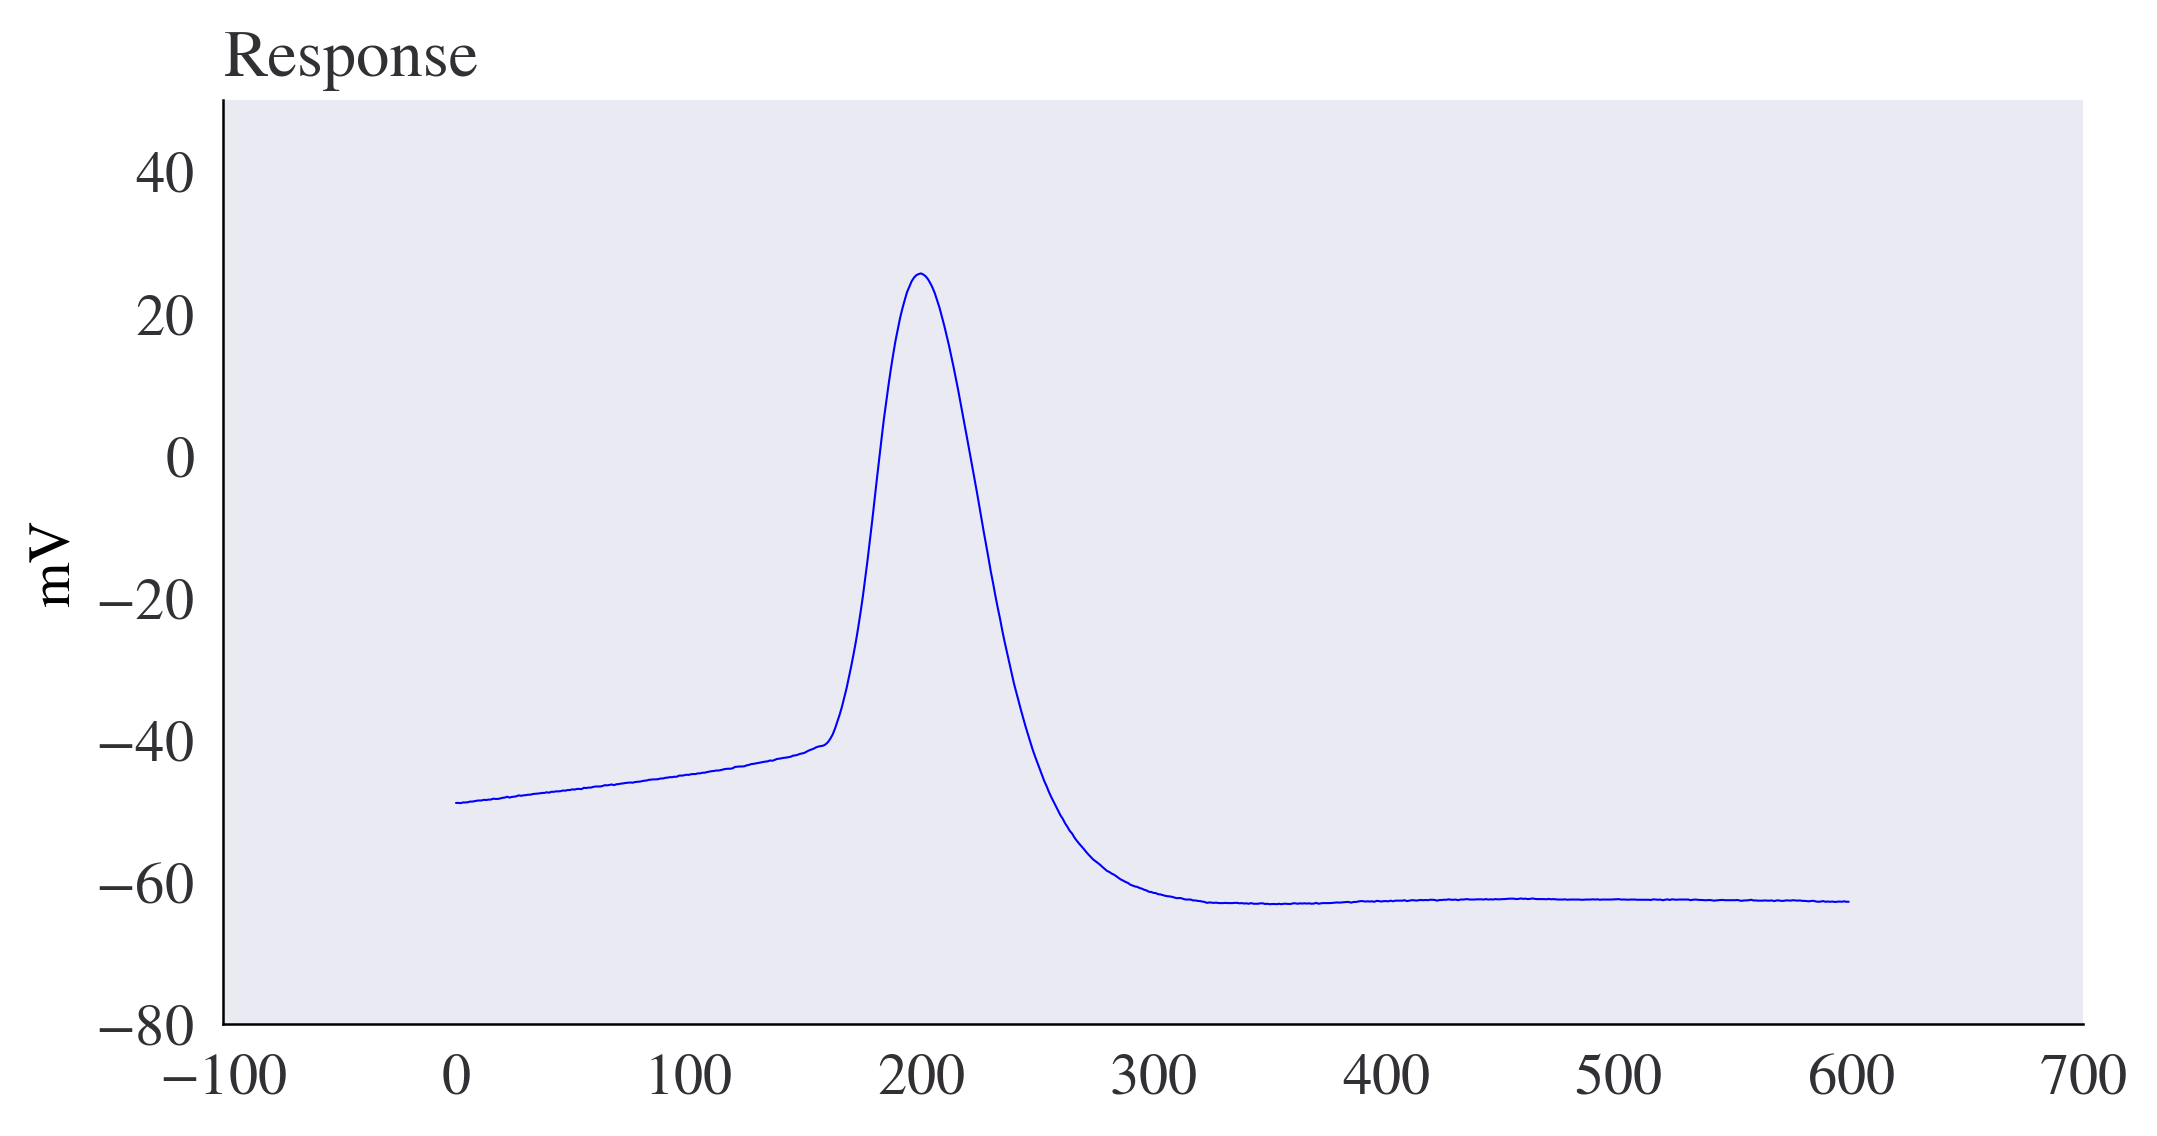

In [18]:
response = np.load('data/single_spike/mouse/pvalb/481127932_11.npy')
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(response, 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('mV')
axes.set_ylim([-80, 50])
axes.set_title('Response')

#### FFT abs

Text(0.0, 1.0, 'Frequency')

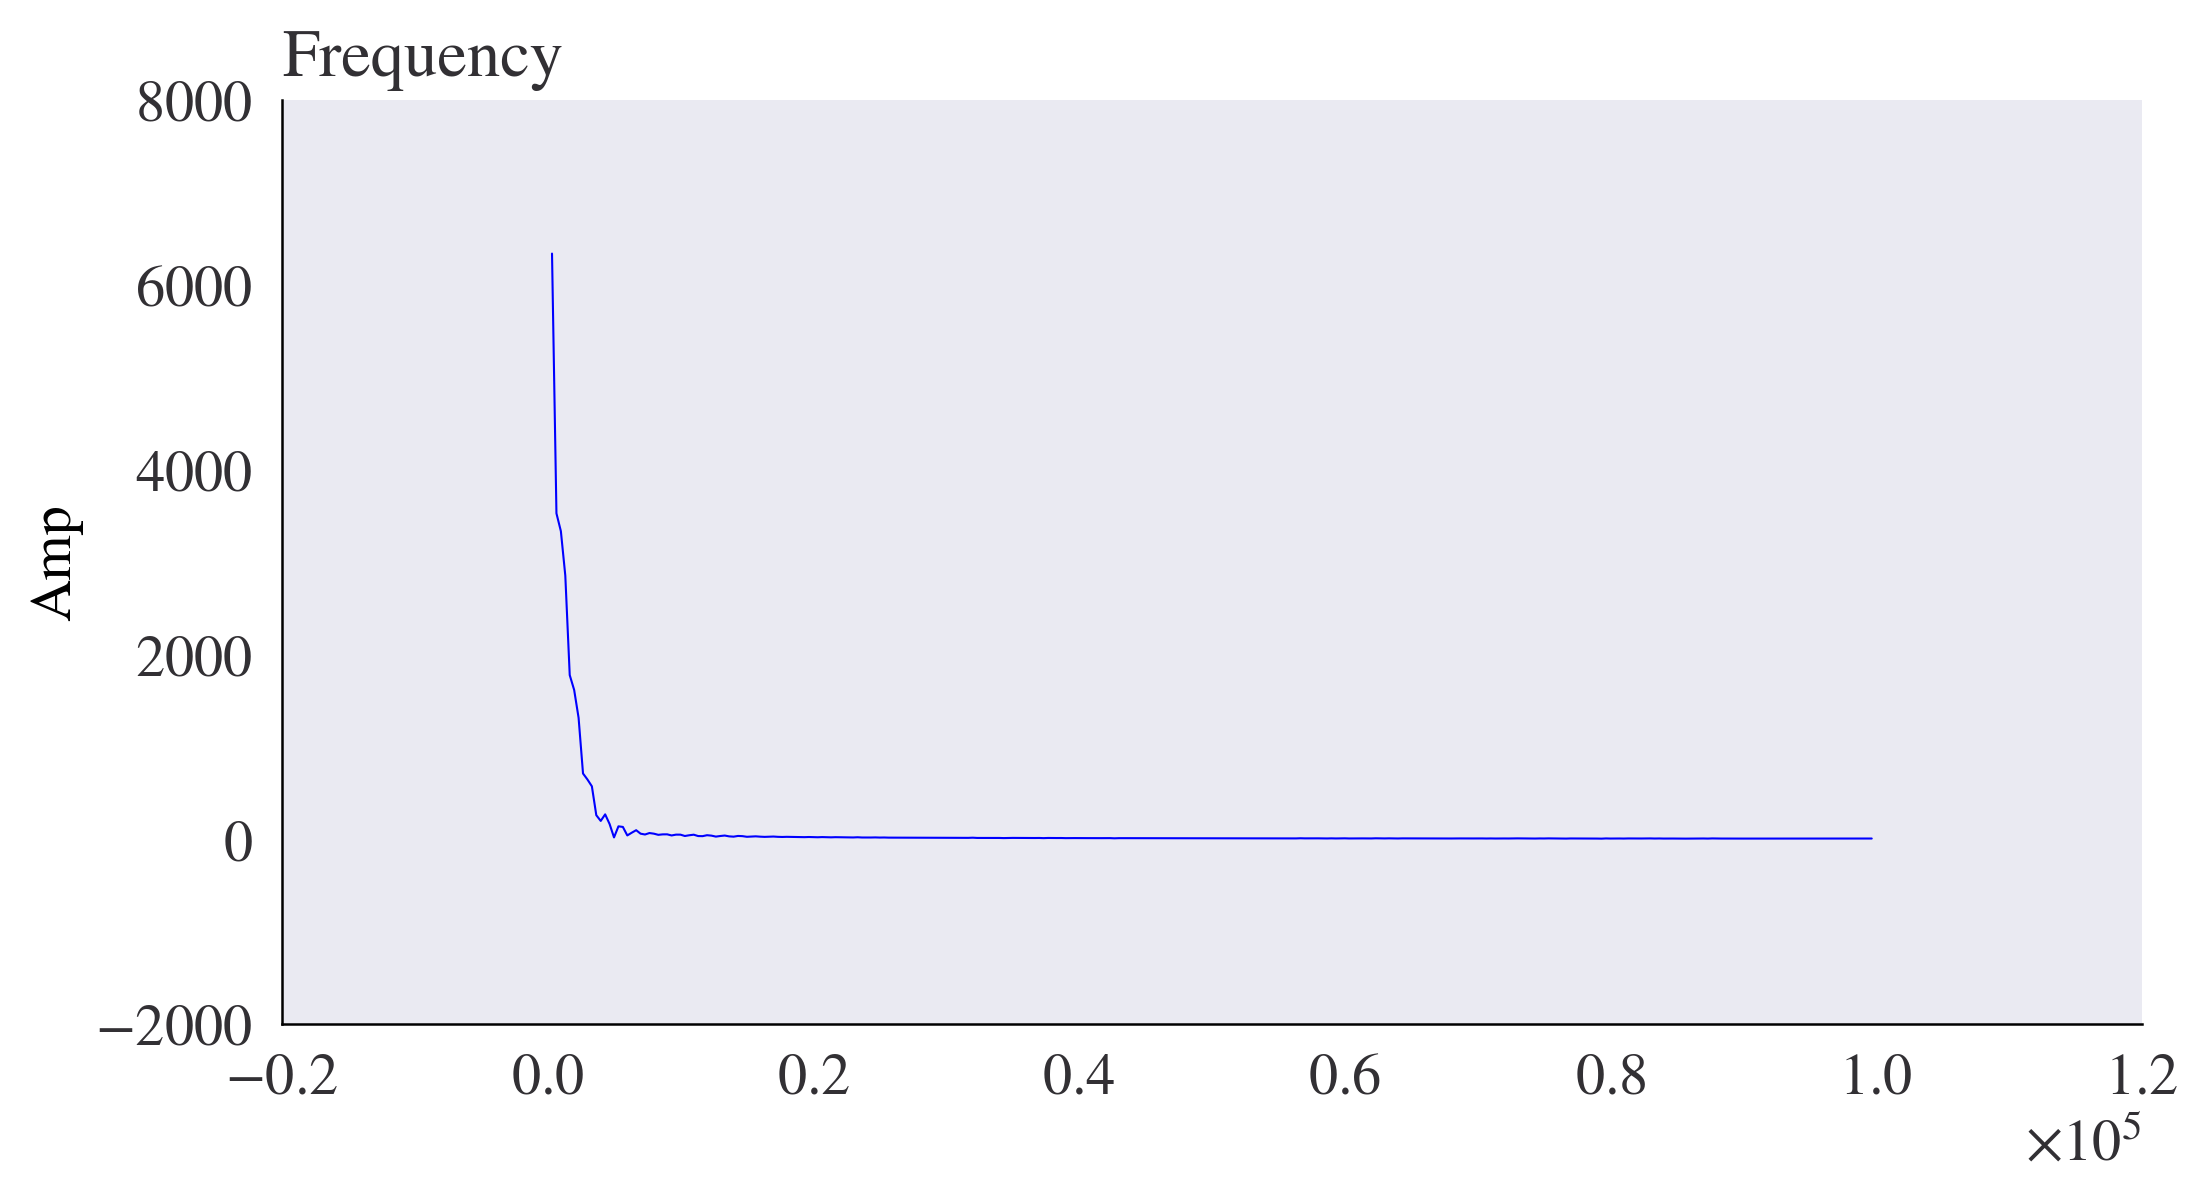

In [19]:
fft = np.load('data/single_spike_fft/mouse/pvalb/481127932_11.npy')
freq = np.fft.fftfreq(fft.size, d=1./sweep_data["sampling_rate"])
max_freq = int(freq.size/2)
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(freq[1:max_freq], np.abs(fft[1:max_freq]), 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('Amp')
axes.set_title('Frequency')

#### FFT real

Text(0.0, 1.0, 'Frequency')

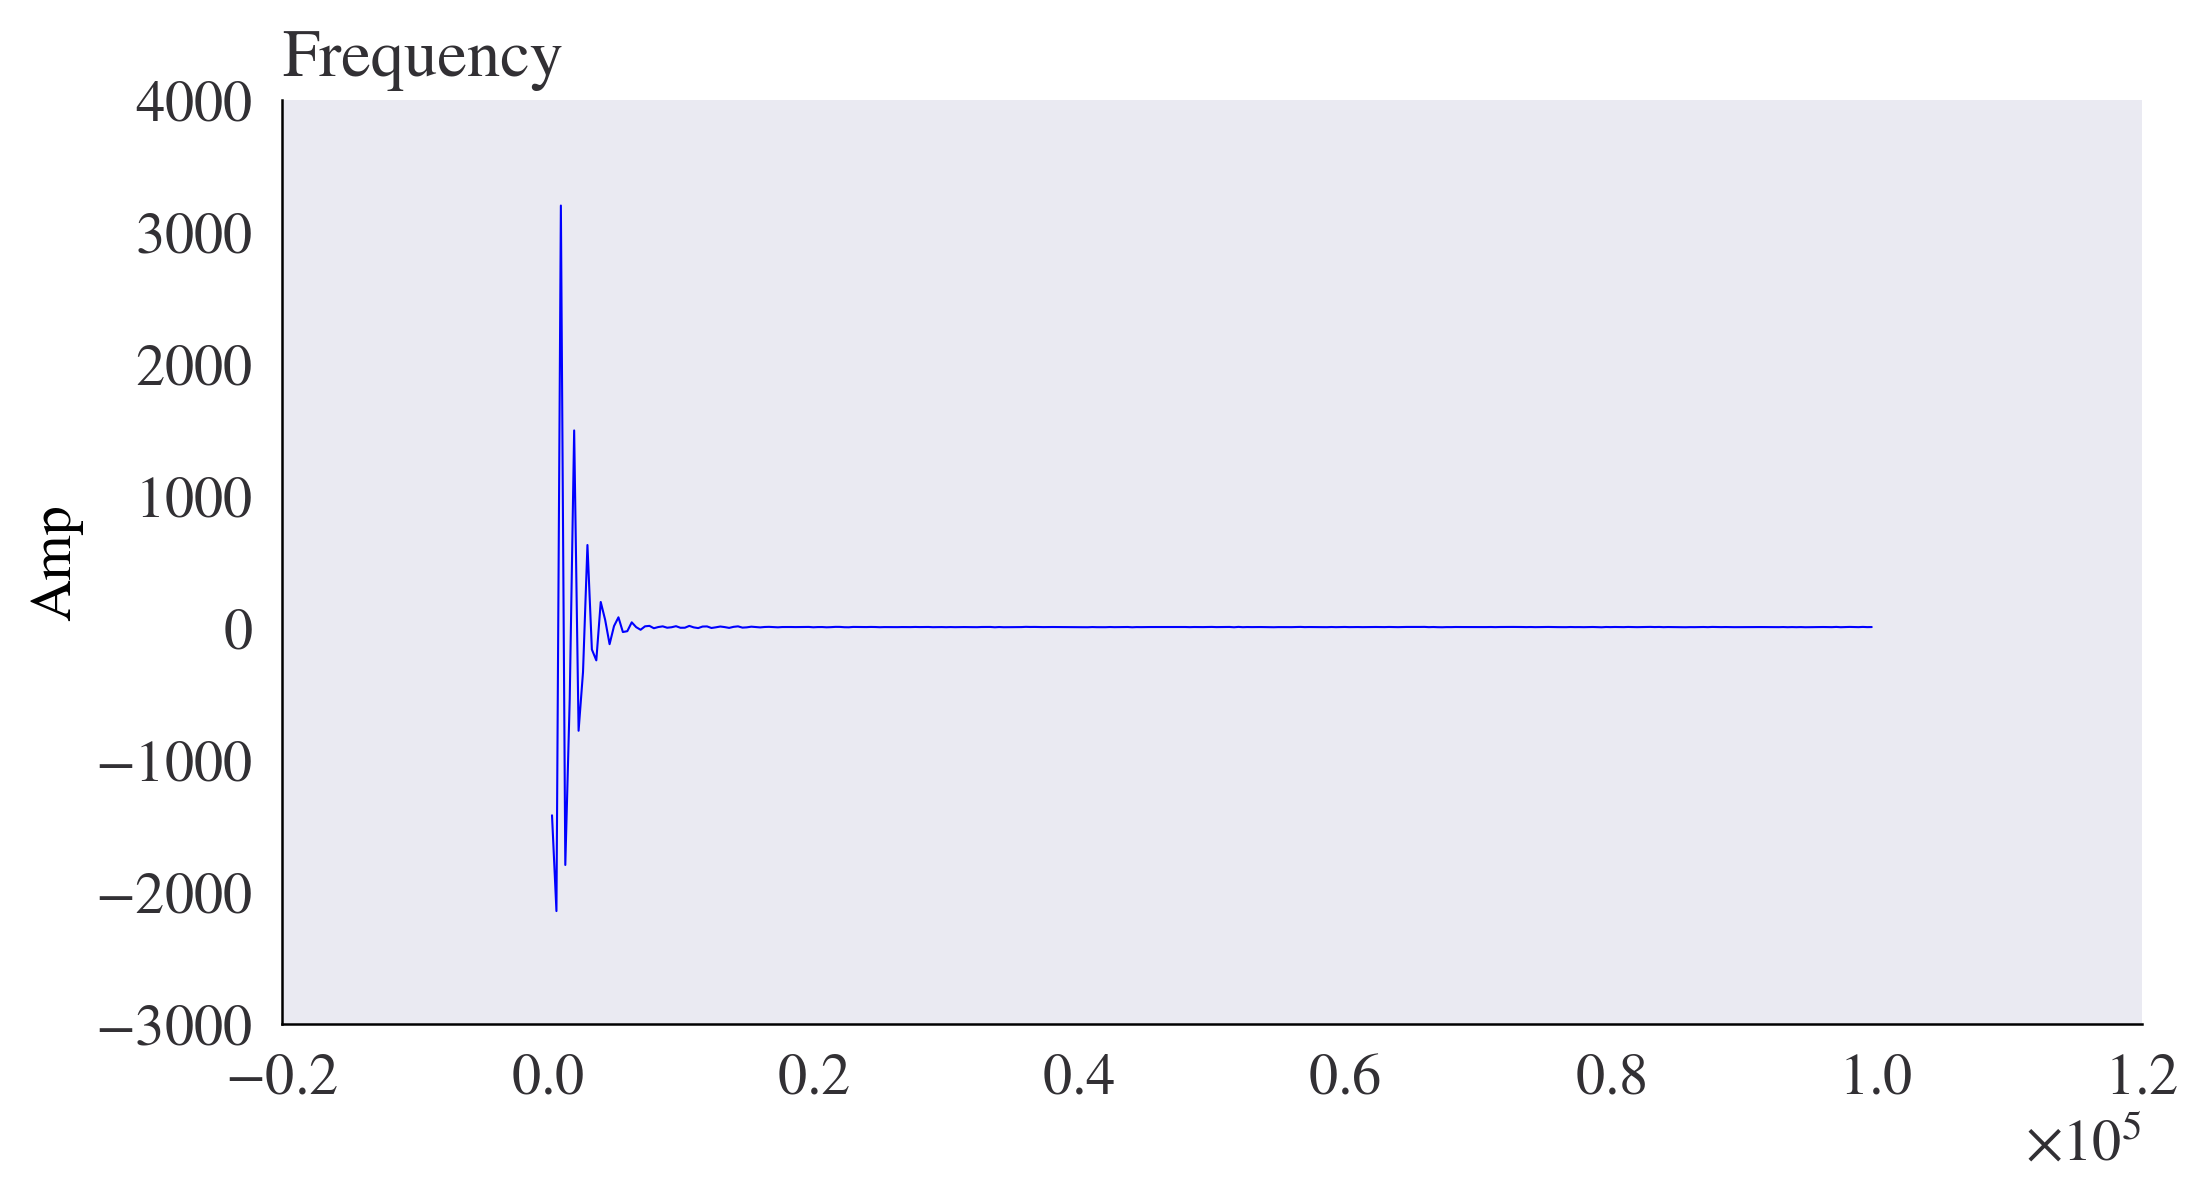

In [20]:
fft = np.load('data/single_spike_fft/mouse/pvalb/481127932_11.npy')
freq = np.fft.fftfreq(fft.size, d=1./sweep_data["sampling_rate"])
max_freq = int(freq.size/2)
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(freq[1:max_freq], fft[1:max_freq].real, 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('Amp')
axes.set_title('Frequency')

#### FFT imaginary

Text(0.0, 1.0, 'Frequency')

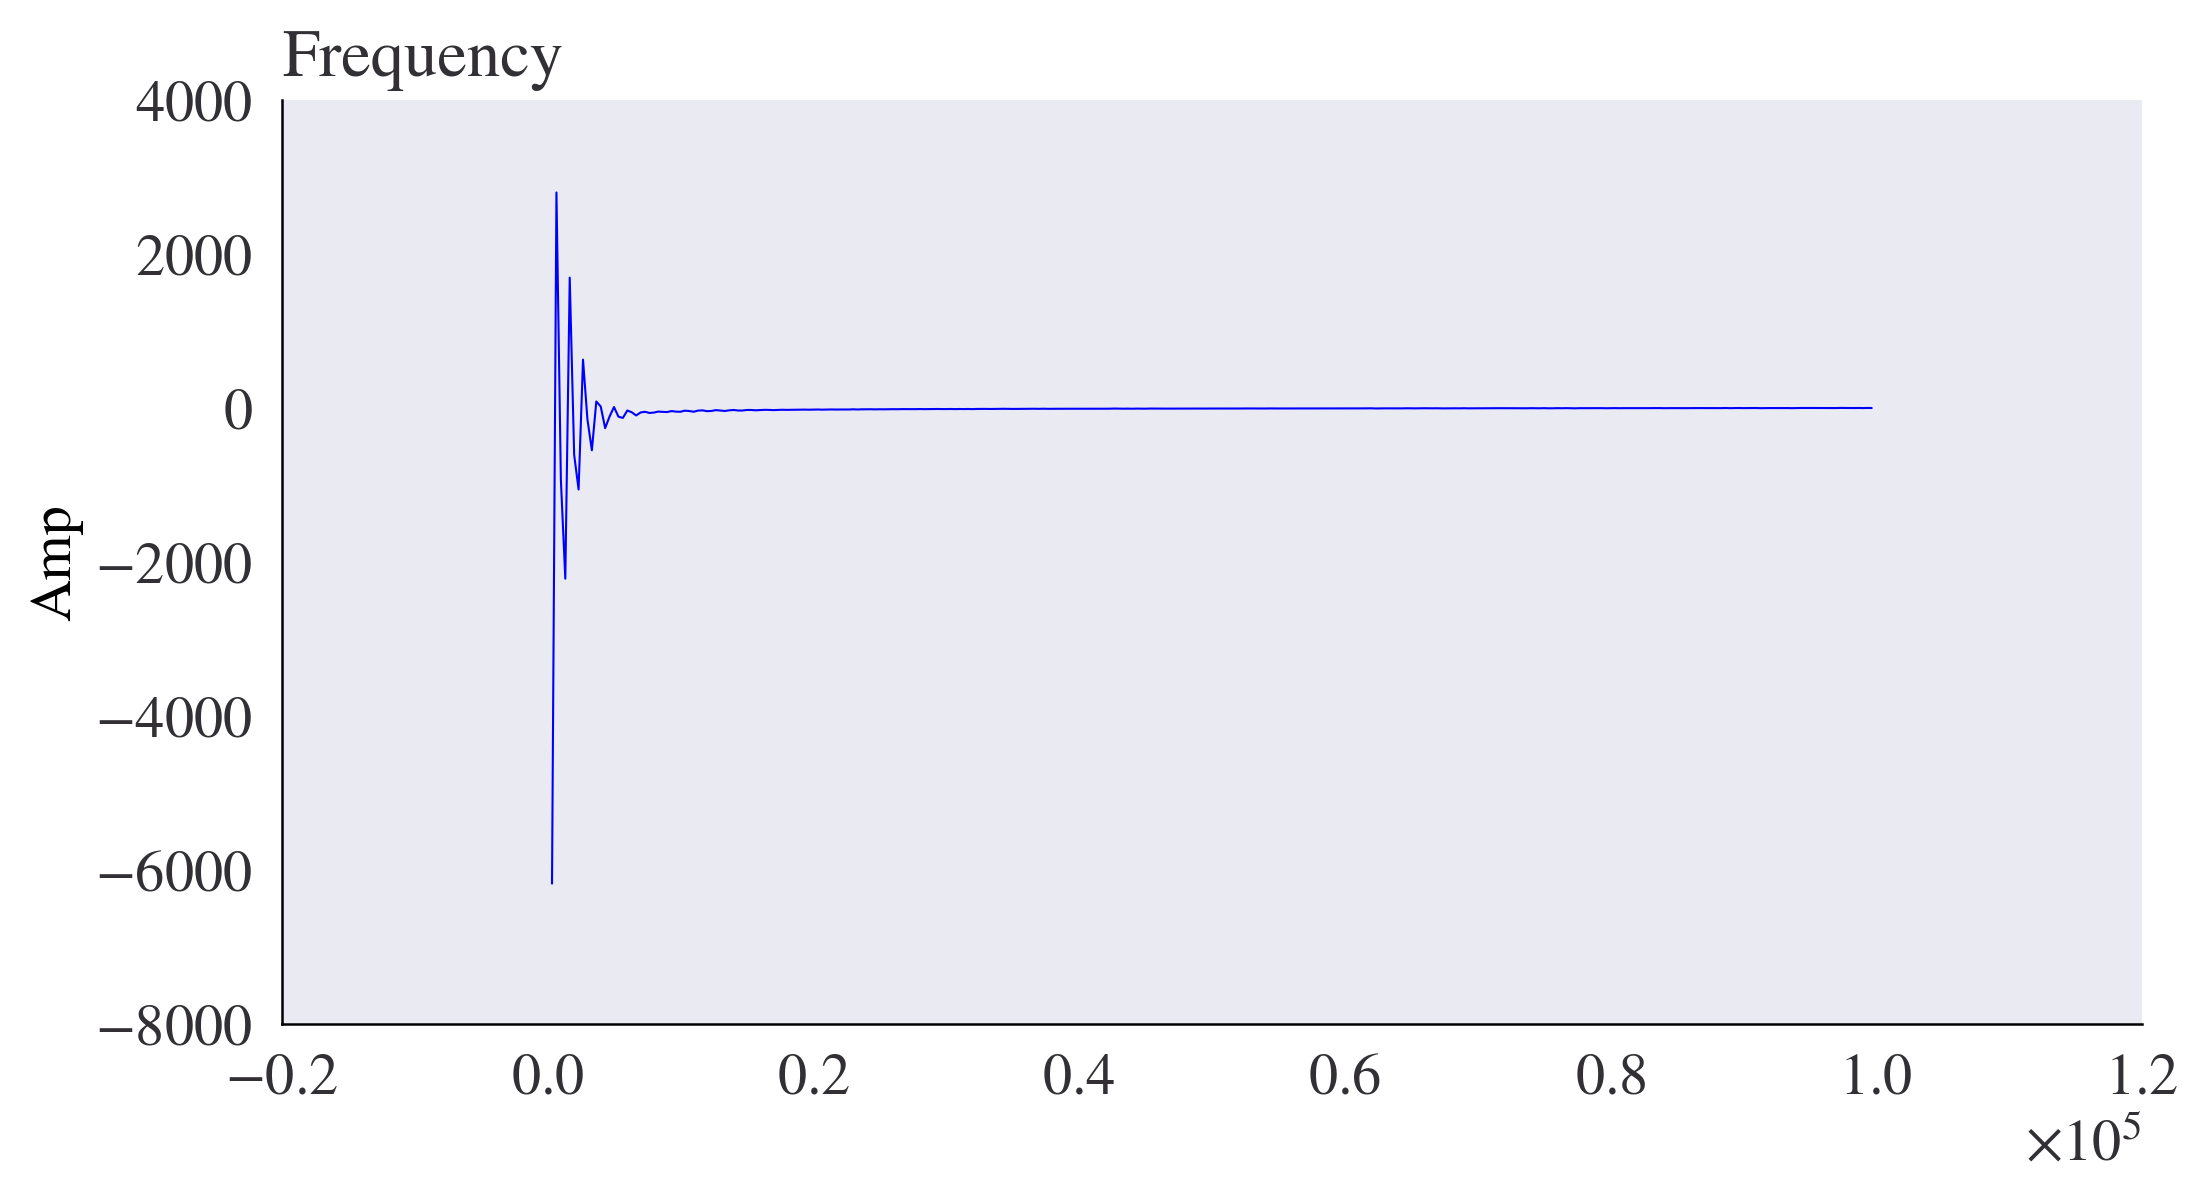

In [21]:
fft = np.load('data/single_spike_fft/mouse/pvalb/481127932_11.npy')
freq = np.fft.fftfreq(fft.size, d=1./sweep_data["sampling_rate"])
max_freq = int(freq.size/2)
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(freq[1:max_freq], fft[1:max_freq].imag, 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('Amp')
axes.set_title('Frequency')

### Analysis on Glutamatergic L4 mouse cell 480087928

#### Short square stimulus

In [22]:
ctc = CellTypesCache()
cell_specimen_id = 480087928
data_set = ctc.get_ephys_data(cell_specimen_id)

sweep_data = data_set.get_sweep(13)

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] * 1e12
v = sweep_data["response"][0:index_range[1]+1] * 1e3
t = np.arange(0, len(v)) * (1.0 / sweep_data["sampling_rate"])

sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i)
sweep_ext.process_spikes()
result = {}
for key in sweep_ext.spike_feature_keys():
    try:
        result[key] = sweep_ext.spike_feature(key)
    except TypeError:
        print("No valid Key")
ephys_data = pd.DataFrame.from_dict(result)

Text(0.0, 1.0, 'Stimulation')

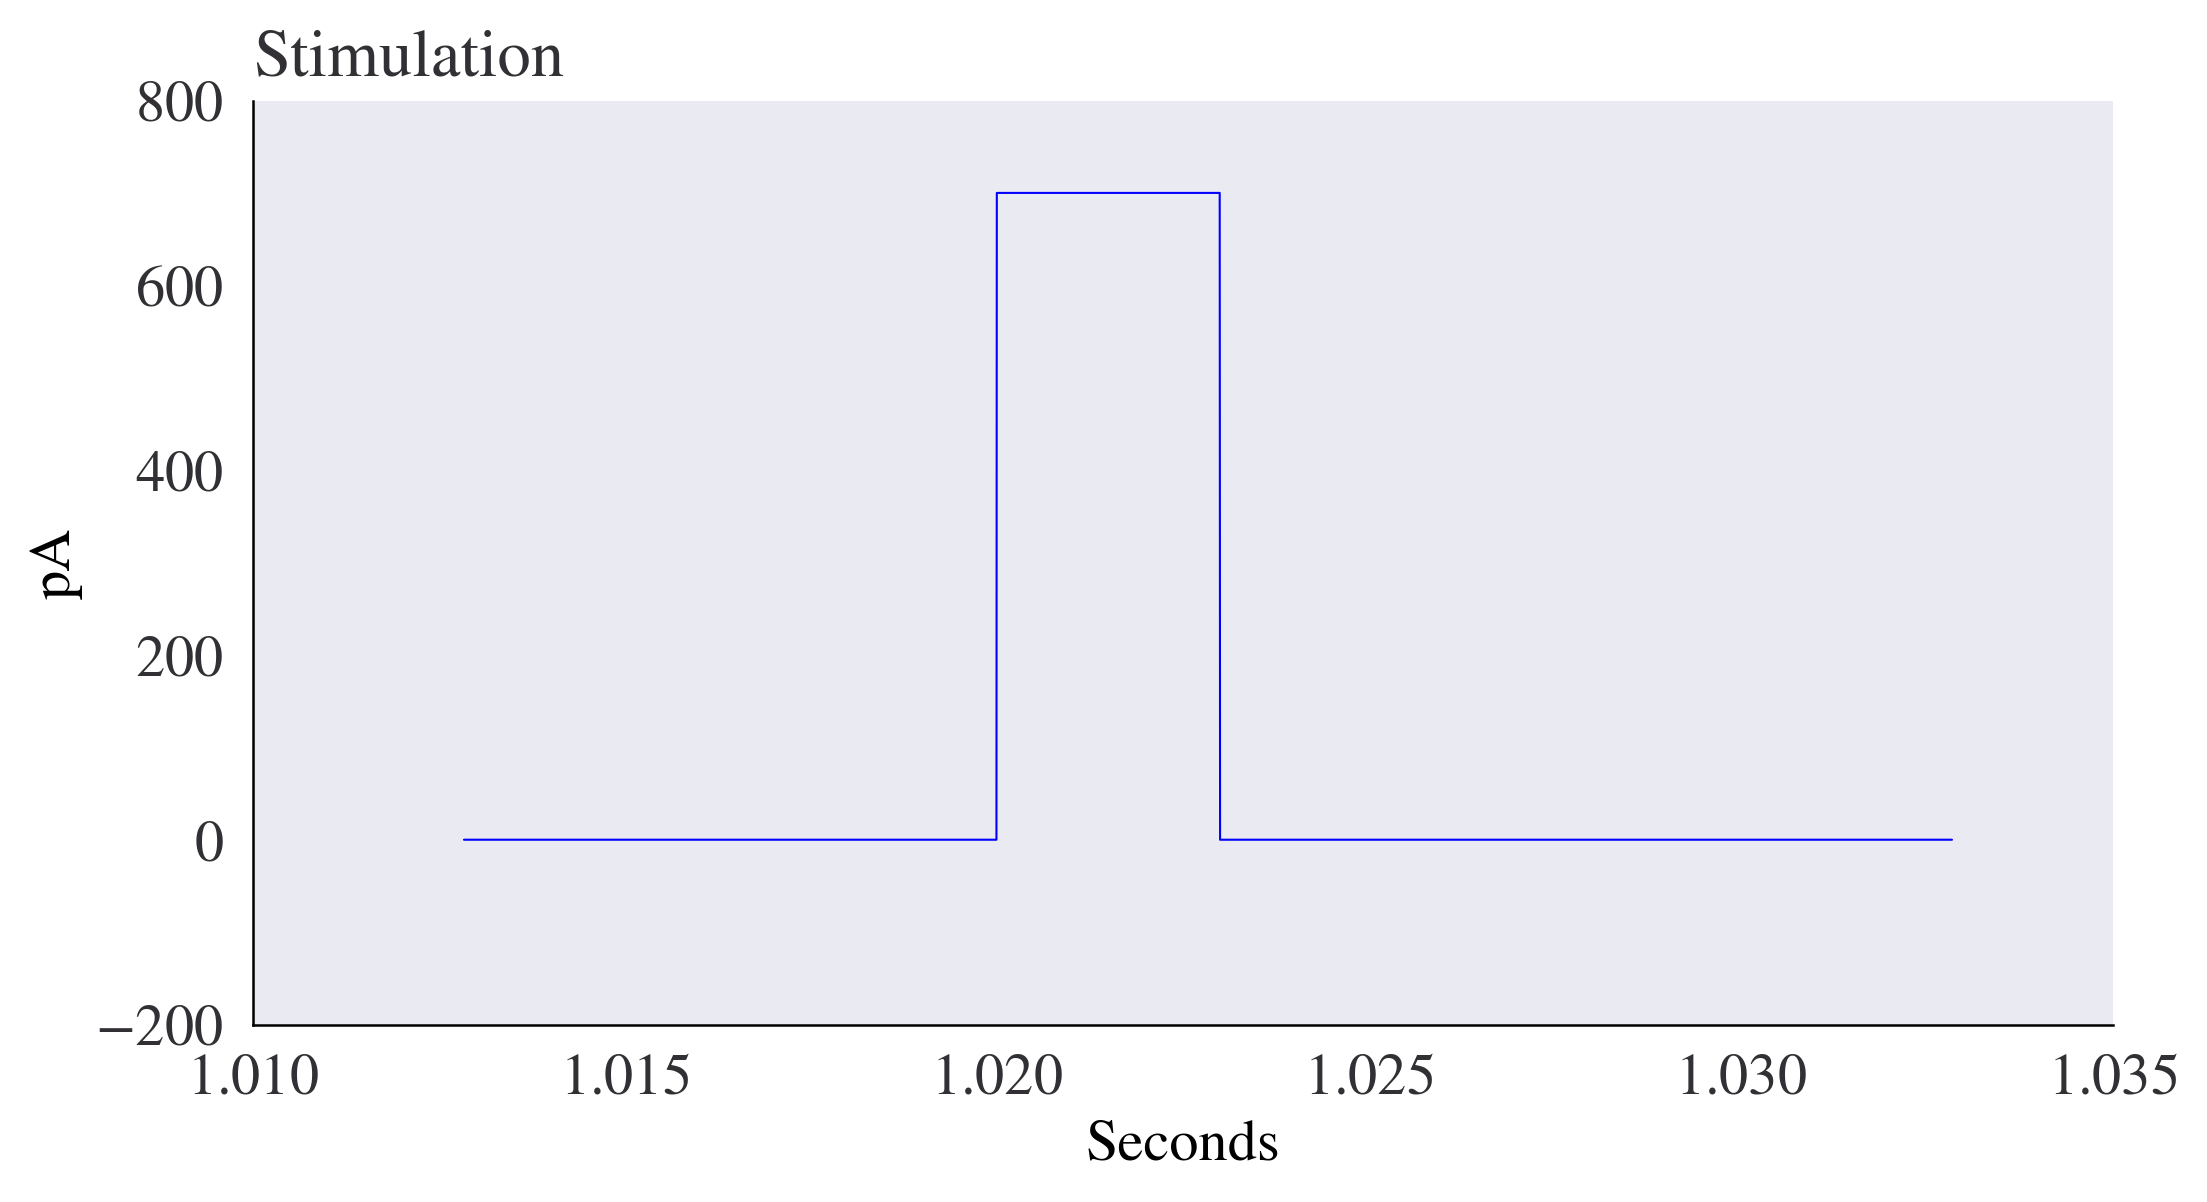

In [23]:
buffer = 2000
index = ephys_data['threshold_index'][0]
stimuli = i[index-buffer:index+buffer]
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(np.linspace(t[index-buffer], t[index+buffer], len(stimuli)), stimuli, 'b-', linewidth=0.5, alpha=1)
axes.set_xlabel('Seconds')
axes.set_ylabel('pA')
axes.set_title('Stimulation')

#### Response

Text(0.0, 1.0, 'Response')

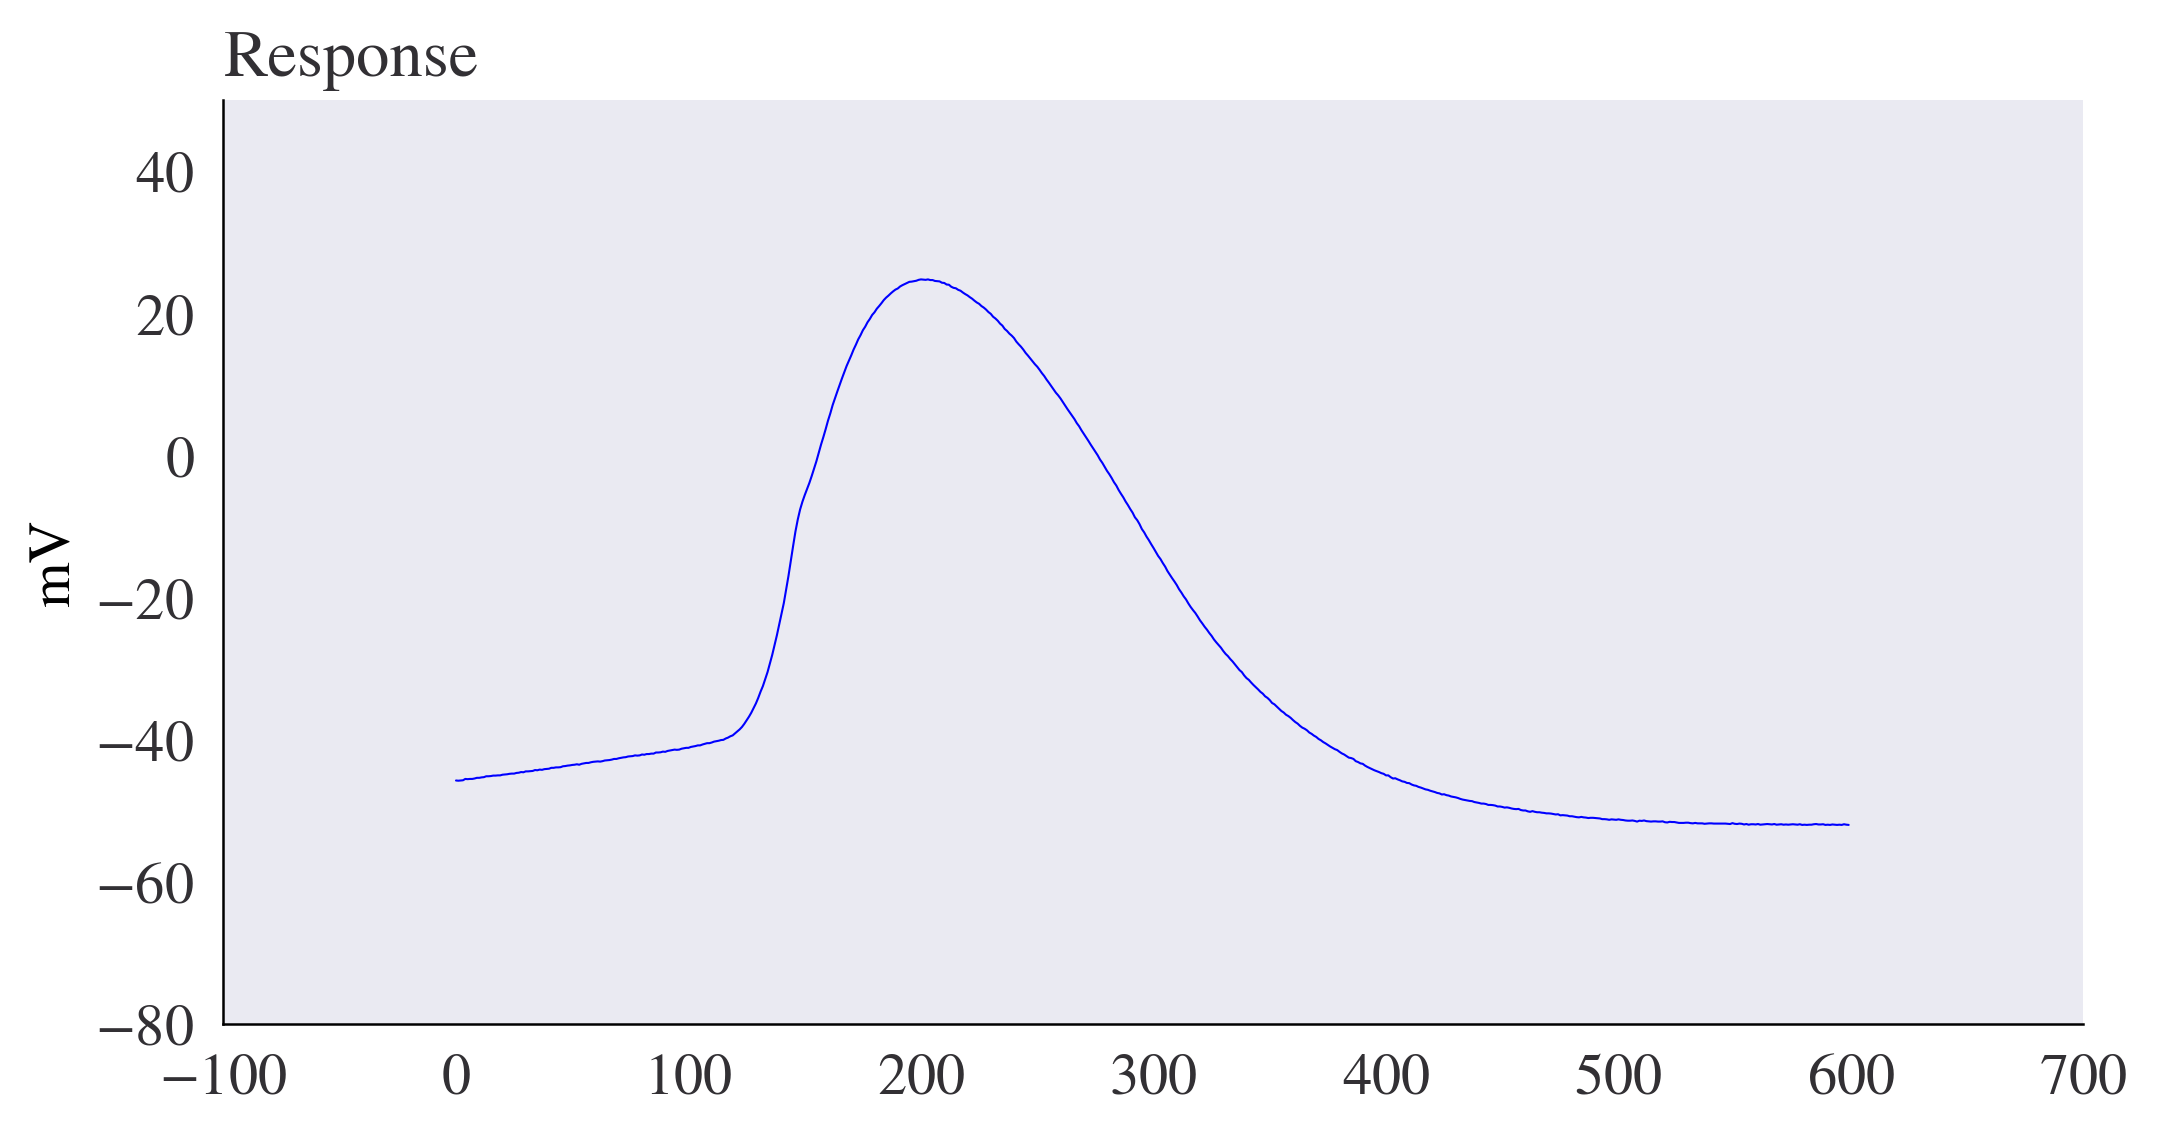

In [24]:
response = np.load('data/single_spike/mouse/glutamatergic/480087928_13.npy')
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(response, 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('mV')
axes.set_ylim([-80, 50])
axes.set_title('Response')

#### FFT abs

Text(0.0, 1.0, 'Frequency')

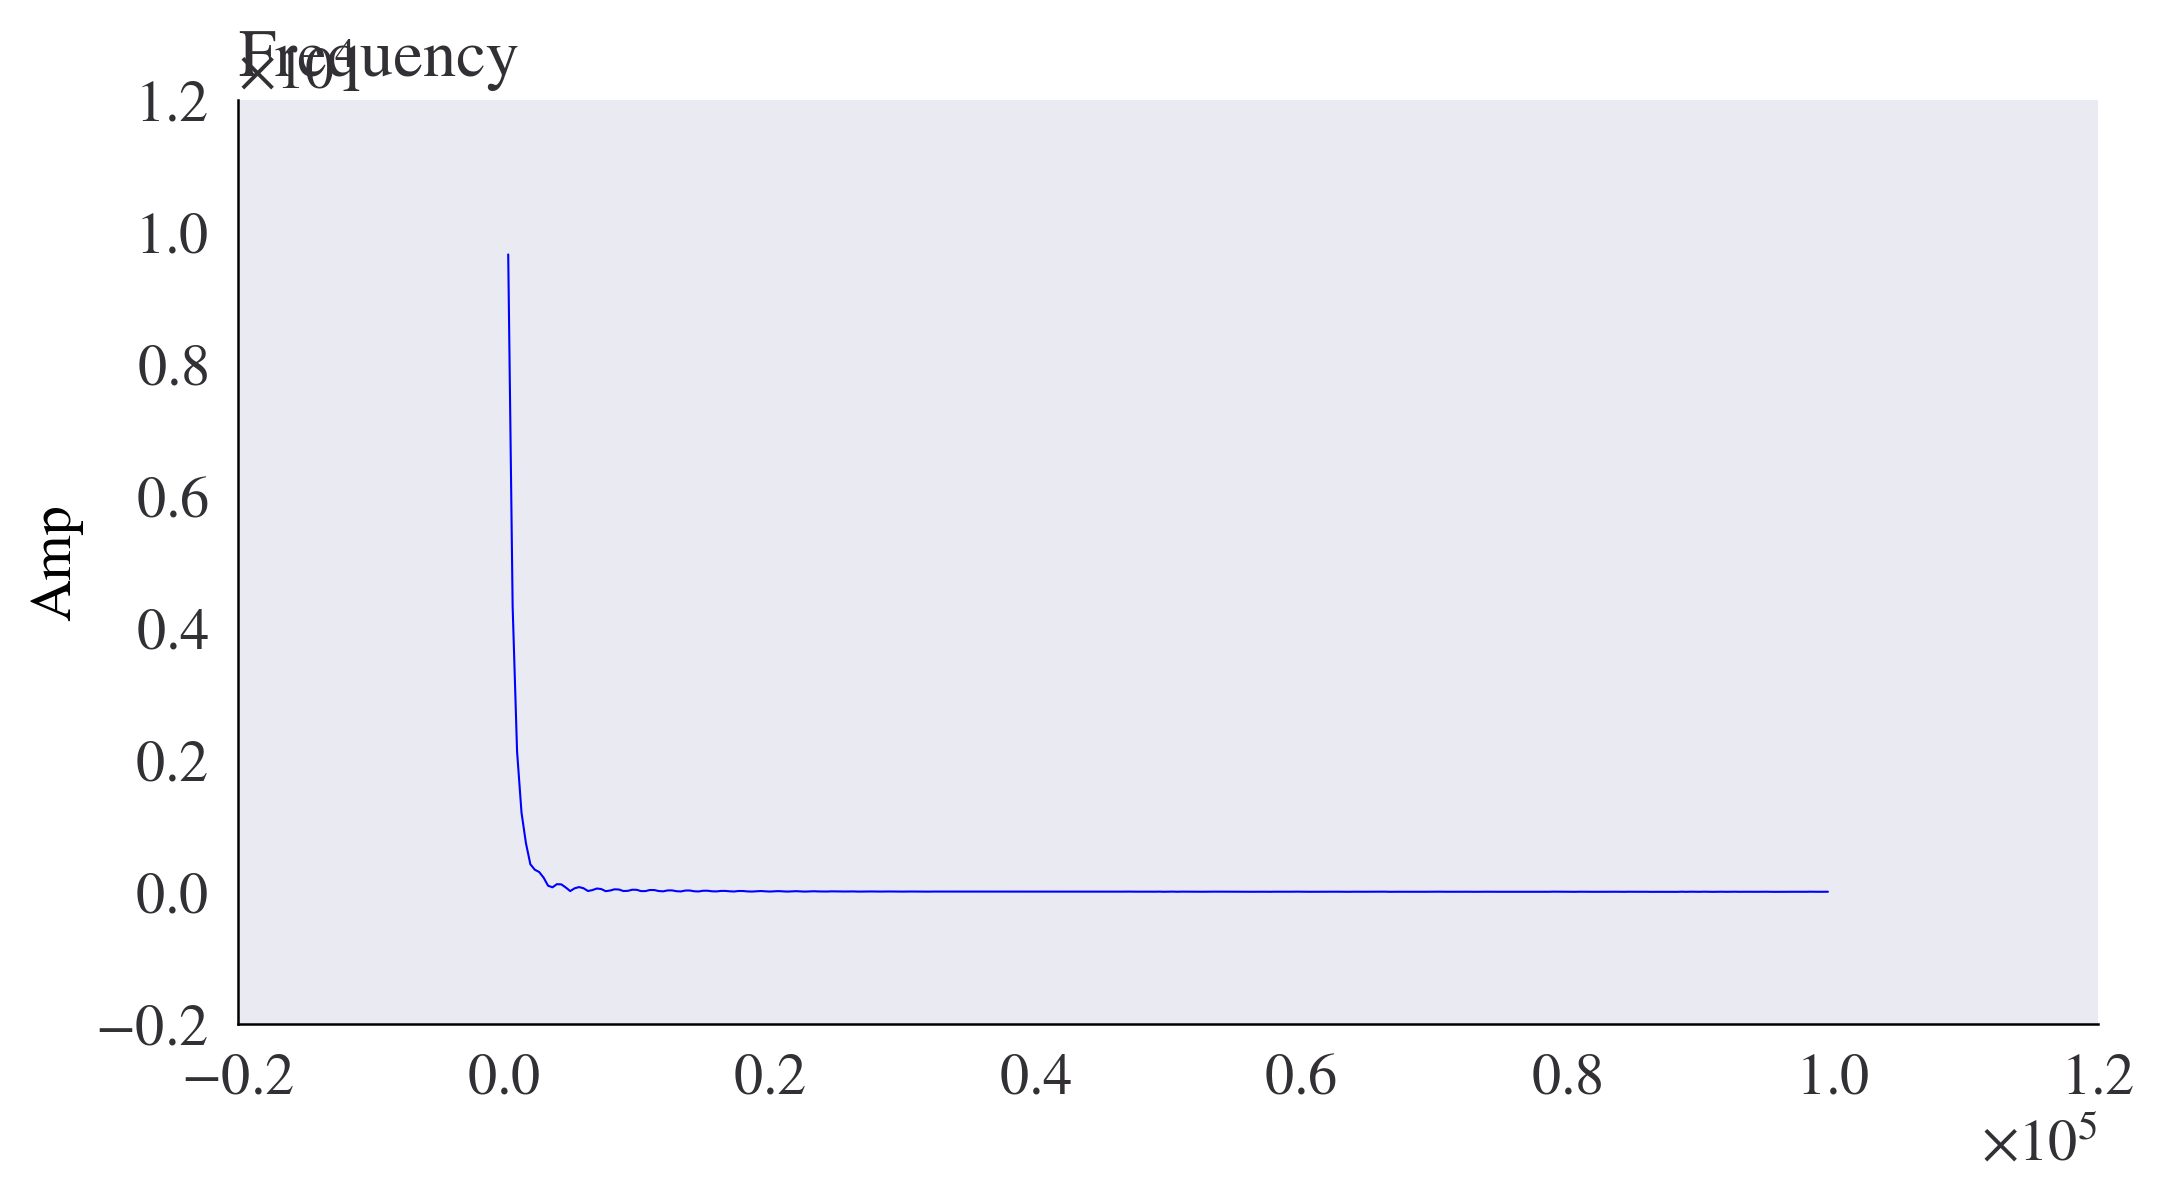

In [25]:
fft = np.load('data/single_spike_fft/mouse/glutamatergic/480087928_13.npy')
freq = np.fft.fftfreq(fft.size, d=1./sweep_data["sampling_rate"])
max_freq = int(freq.size/2)
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(freq[1:max_freq], np.abs(fft[1:max_freq]), 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('Amp')
axes.set_title('Frequency')

#### FFT real

Text(0.0, 1.0, 'Frequency')

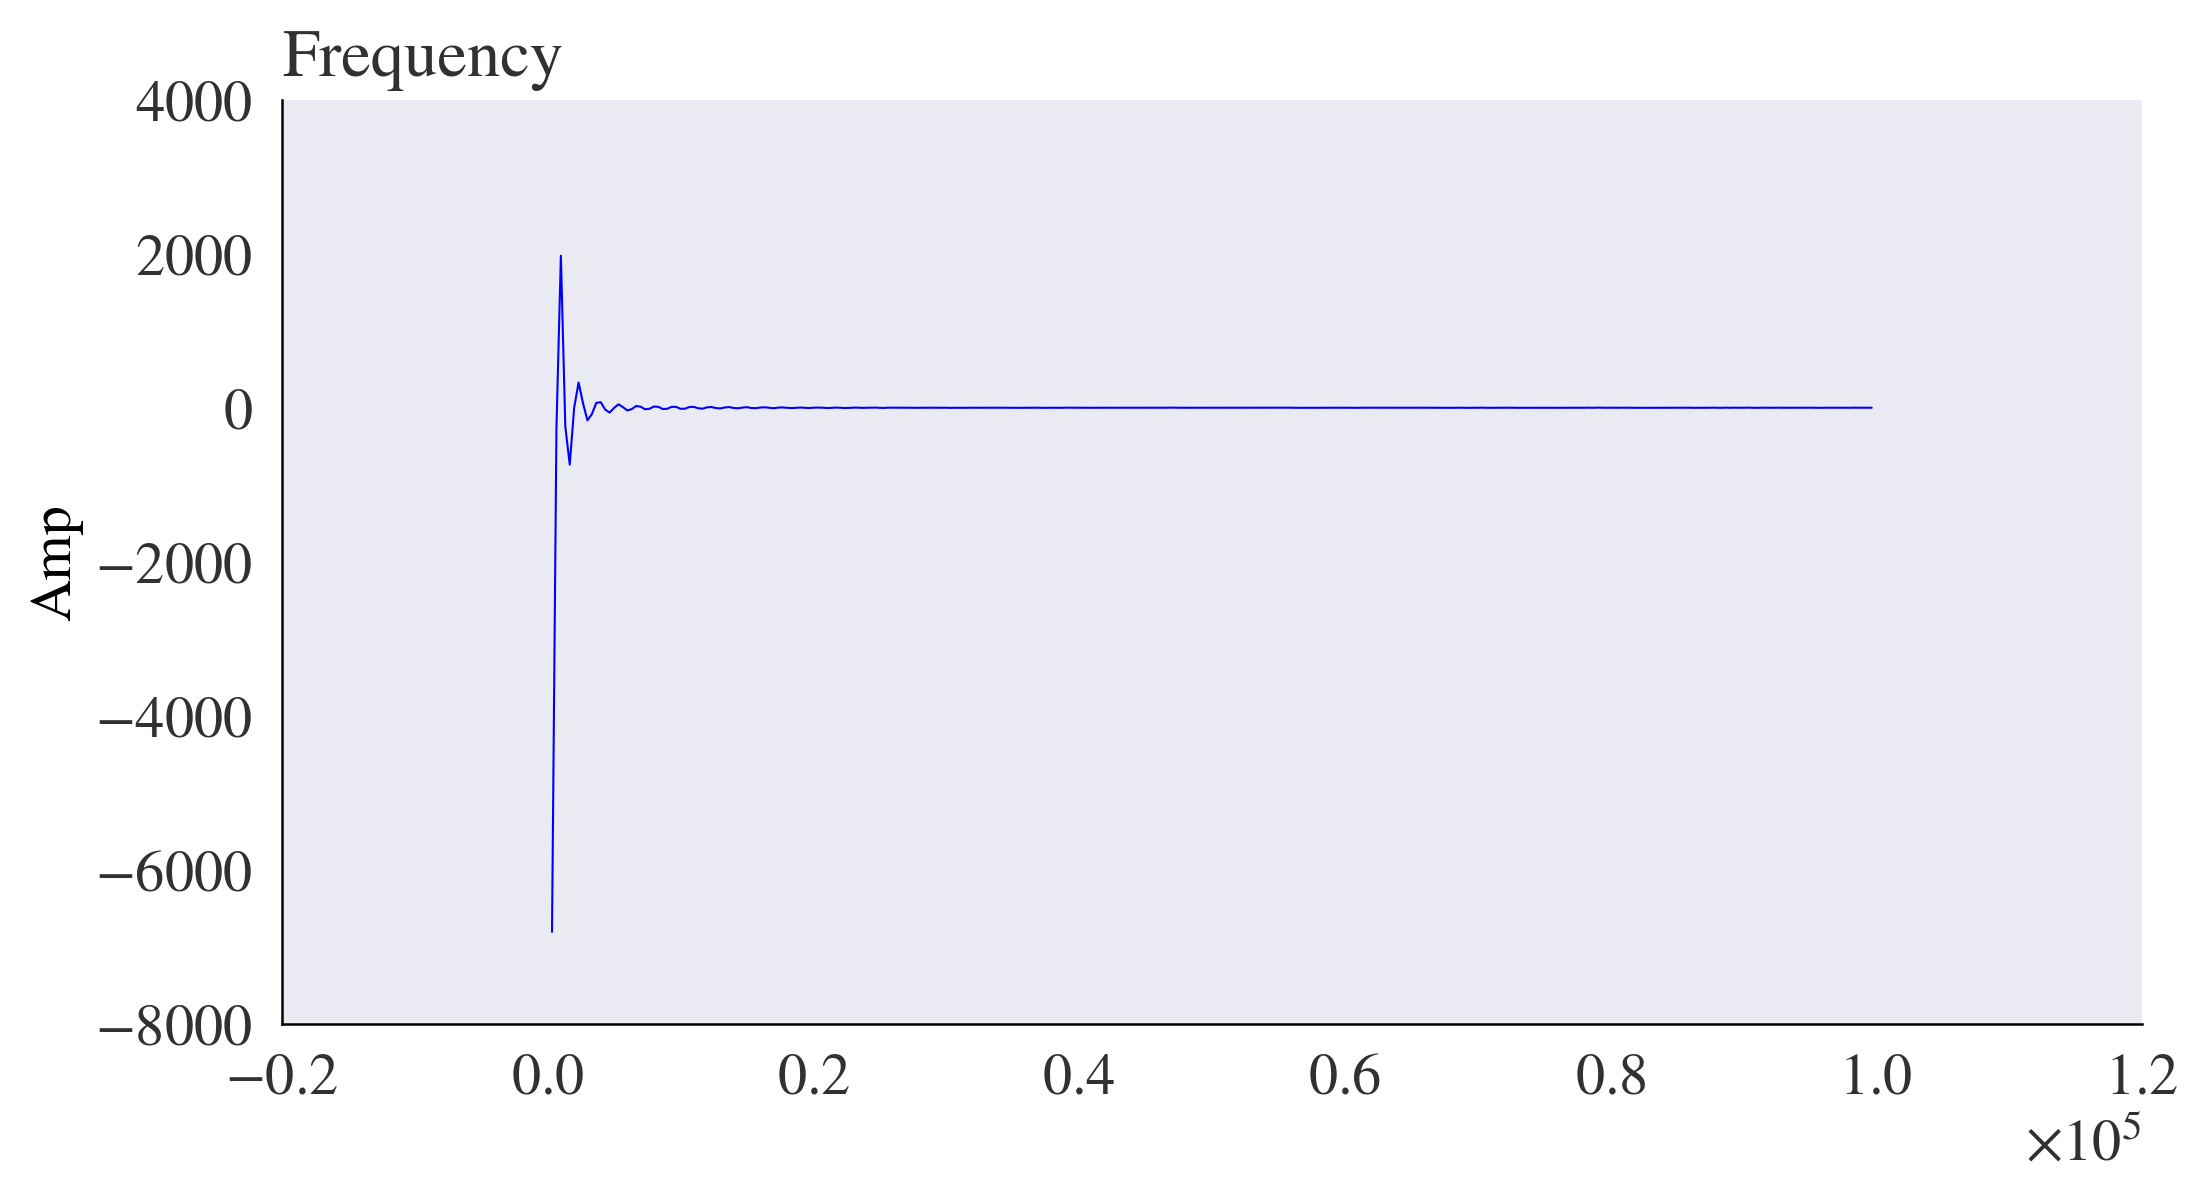

In [26]:
fft = np.load('data/single_spike_fft/mouse/glutamatergic/480087928_13.npy')
freq = np.fft.fftfreq(fft.size, d=1./sweep_data["sampling_rate"])
max_freq = int(freq.size/2)
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(freq[1:max_freq], fft[1:max_freq].real, 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('Amp')
axes.set_title('Frequency')

#### FFT imaginary

Text(0.0, 1.0, 'Frequency')

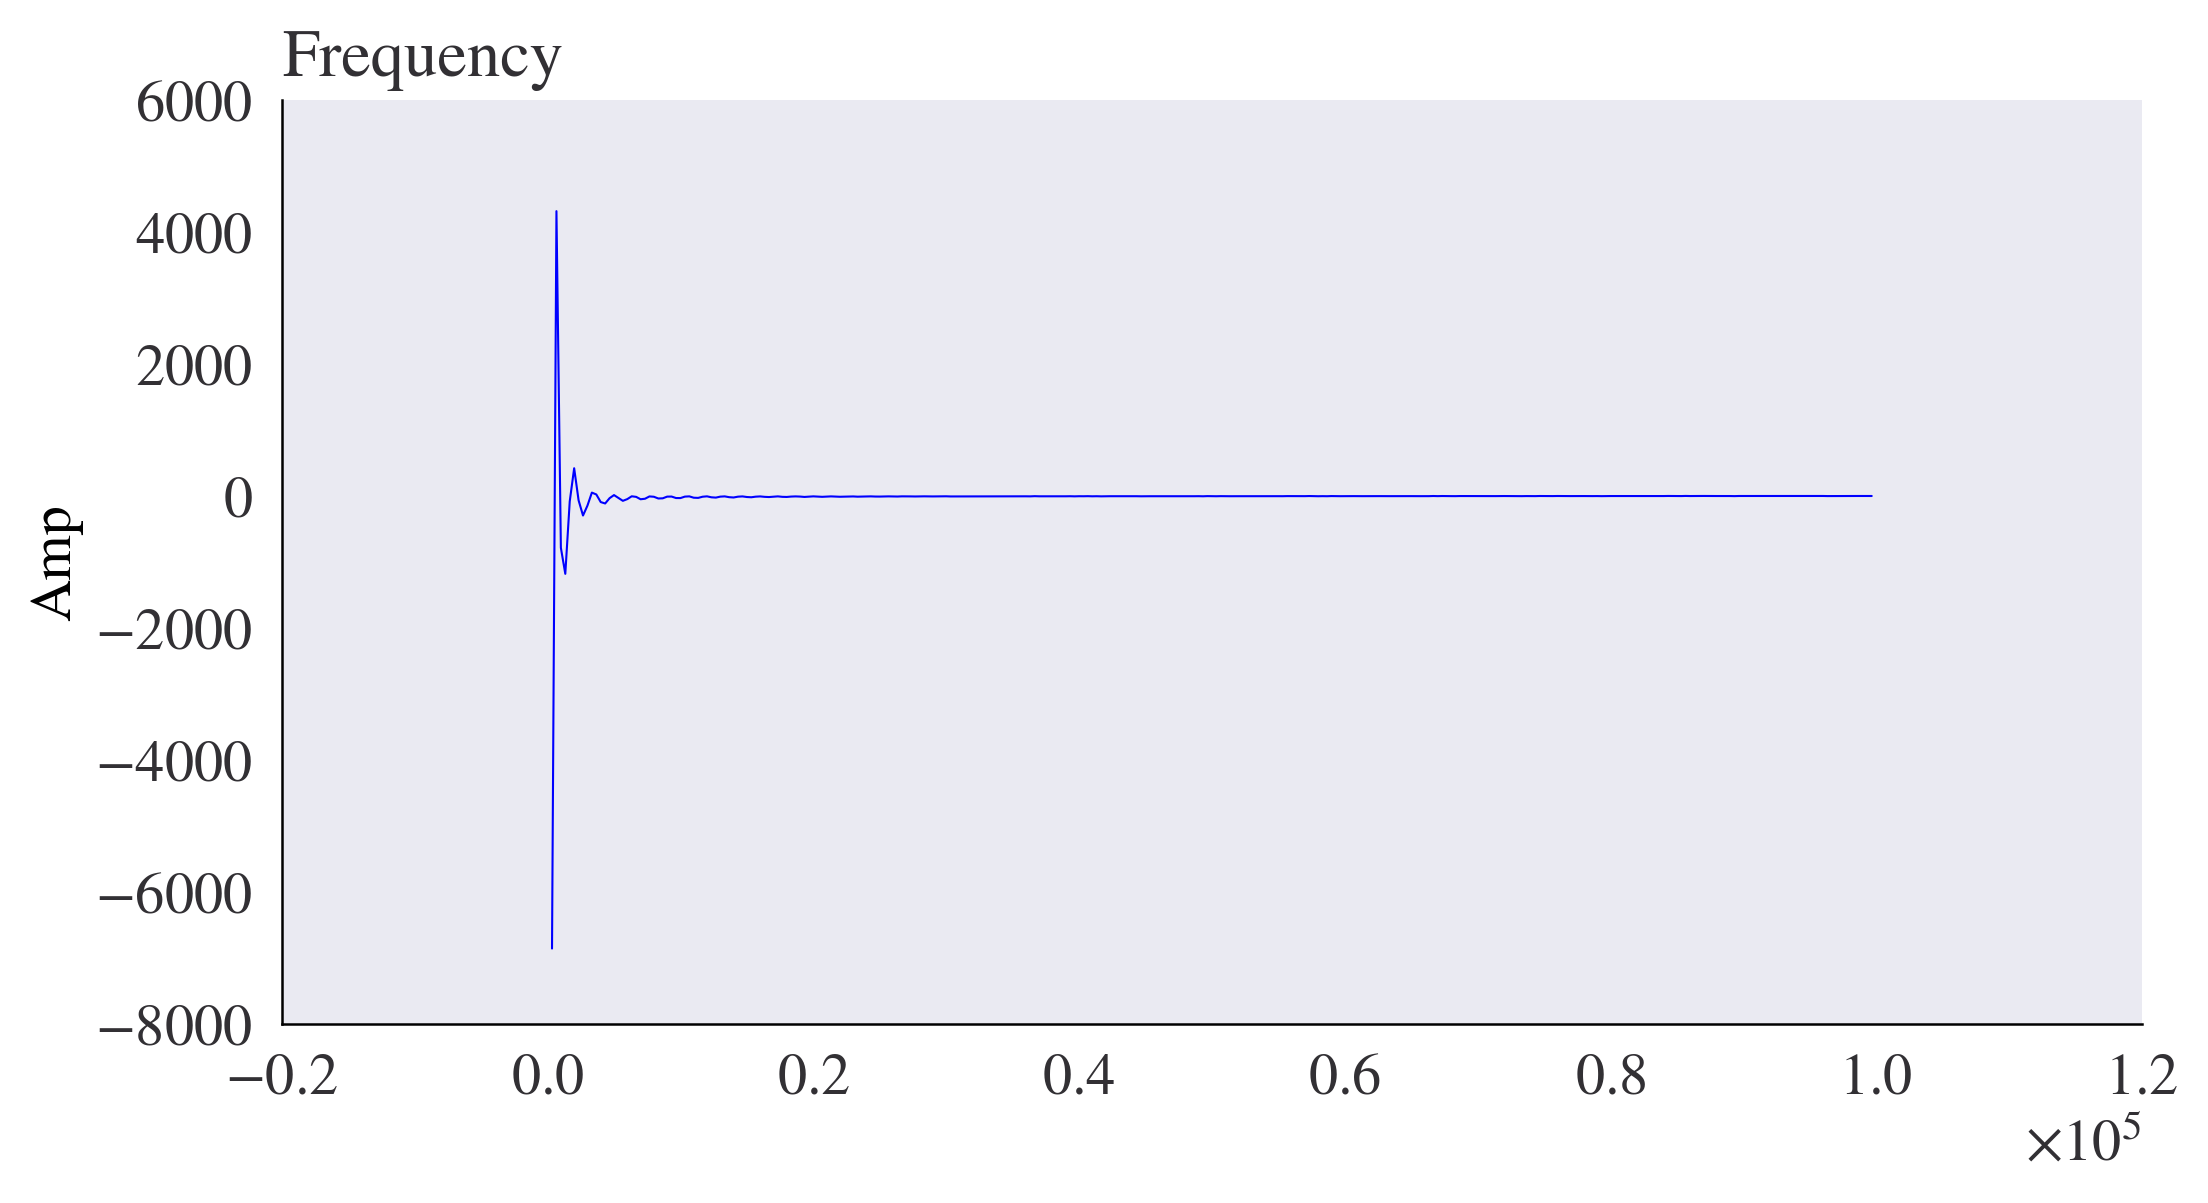

In [27]:
fft = np.load('data/single_spike_fft/mouse/glutamatergic/480087928_13.npy')
freq = np.fft.fftfreq(fft.size, d=1./sweep_data["sampling_rate"])
max_freq = int(freq.size/2)
fig, axes = plt.subplots(1, 1, figsize=(8, 4))
axes.plot(freq[1:max_freq], fft[1:max_freq].imag, 'b-', linewidth=0.5, alpha=1)
axes.set_ylabel('Amp')
axes.set_title('Frequency')